In [1]:
import math

import lightgbm
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import *
from sklearn.gaussian_process import GaussianProcessRegressor

from rshdmrgpr.rs_hdmr_gpr import *

This notebook supplements the research paper:  
  
<font color='red'>**Random Sampling High Dimensional Model Representation Gaussian Process Regression (RS-HDMR-GPR): a code for representing multidimensional functions with lower-dimensional terms**</font>
    
The following sections contains code that generated the figures in Sections 3.1 - 3.3.

In [2]:
def plot_for_paper(y, y_pred, xlabel=None, ylabel=None, ticksize=14, fig_size=None, name=None, save=False, sn=False):
    if fig_size:
        plt.figure(figsize=fig_size)
    else:
        plt.figure()
        
    if sn:
        plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    if xlabel:
        plt.xlabel(xlabel, size=24)
    if ylabel:
        plt.ylabel(ylabel, size=24)
    plt.scatter(y, y_pred, c='b', s=3)
    plt.grid()
    if save:
        if name is None:
            raise RuntimeError(f'name argument must be provided if save is True.')
        plt.savefig(name, dpi=800, bbox_inches='tight')
    else:
        plt.show()

In [3]:
def data_summary(data):
    data.info()
    print()
    print(data.memory_usage())
    print()
    for c in data.columns:
        print(f'{c:<10} Max Value: {data[c].max():<10.4f}  Min Value: {data[c].min():<10.4f}')

#### Section 3.1 - H<sub>2</sub>O Data Set.

In [4]:
data = pd.read_csv('rshdmrgpr/datasets/h2o.dat', sep='\s+', names=['a1', 'a2', 'a3', 'out'])

In [5]:
# This is the shape of data
data.head(2)

,a1,a2,a3,out
0,0.93809,0.93809,-0.30414,0.01220
1,1.19886,0.95341,-0.58120,10835.41567


In [6]:
# Prints information regarding the data.
data_summary(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a1      10001 non-null  float64
 1   a2      10001 non-null  float64
 2   a3      10001 non-null  float64
 3   out     10001 non-null  float64
dtypes: float64(4)
memory usage: 312.7 KB

Index      128
a1       80008
a2       80008
a3       80008
out      80008
dtype: int64

a1         Max Value: 1.3877      Min Value: 0.7148    
a2         Max Value: 1.4134      Min Value: 0.7179    
a3         Max Value: 0.6211      Min Value: -0.9997   
out        Max Value: 19946.4188  Min Value: 0.0122    


In [7]:
scale = data['out'].max() - data['out'].min()
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data)
data_scaled = pd.DataFrame(scaler.transform(data), columns=['a1', 'a2', 'a3', 'out'])

In [8]:
# Picks out 1000 entries for training
x_train, x_test, y_train, y_test = train_test_split(data_scaled, data_scaled['out'], train_size=1000, test_size=None, random_state=42)

In [9]:
# Trains 3 models: The 1d-hdmr, 2d-hdmr and the 2d*-hdmr
d = data.shape[1] - 1
matrices1, kernels1 = kernel_matrices(1, d, 0.6)
matrices2, kernels2 = kernel_matrices(2, d, 0.6)
matrices3 = [np.array([[1, 0], [0, 1], [0, 1]]), np.array([[1, 0], [1, 0], [0, 1]]), np.array([[1, 0], [0, 1], [1, 0]])]
kernels3 = kernels2

In [10]:
# Initializes the Model classes for training
hdmr1 = RSHDMRGPR(len(matrices1), matrices1, kernels1)
hdmr2 = RSHDMRGPR(len(matrices2), matrices2, kernels2)
hdmr3 = RSHDMRGPR(len(matrices3), matrices3, kernels3)

In [11]:
# Trains the three models. The third model returns the rmse values on the training set across cycles. Number of cycles
# is default to 50.
hdmr1.train(x_train, alphas=1e-11)
hdmr2.train(x_train, alphas=1e-11)
_, df_rmse3 = hdmr3.train(x_train, alphas=1e-11, scale_down=(0.1, 2), report_rmse=True)

Training iteration for cycle 1 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 2 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 3 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 4 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 5 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 6 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 7 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 8 has starte

In [12]:
models1 = hdmr1.get_models()
models2 = hdmr2.get_models()
models3 = hdmr3.get_models()

<span style='font-family:"Times New Roman"'> <span styel=''><font color='navy'>Component function graphs for the 1d-hdmr model</font>

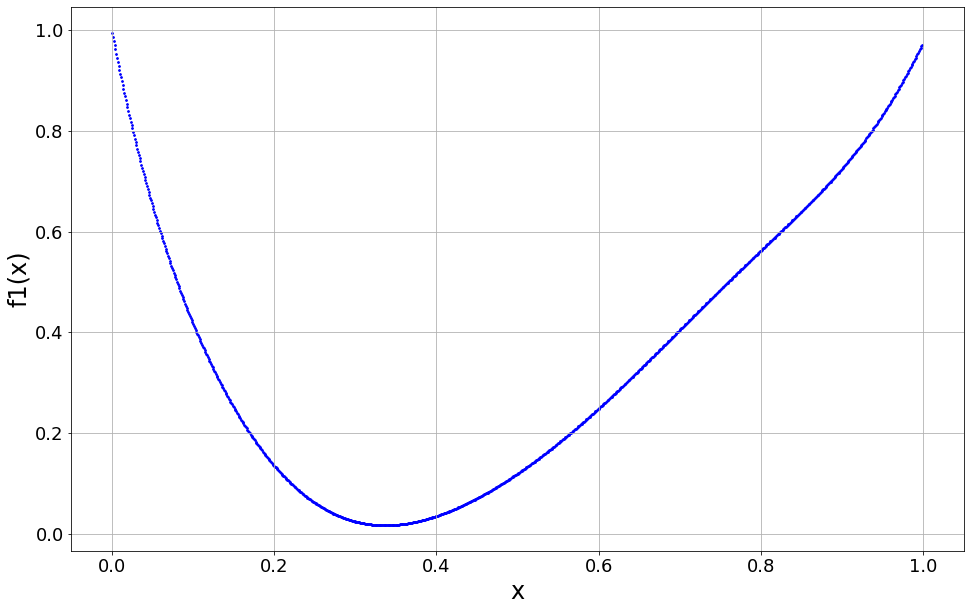

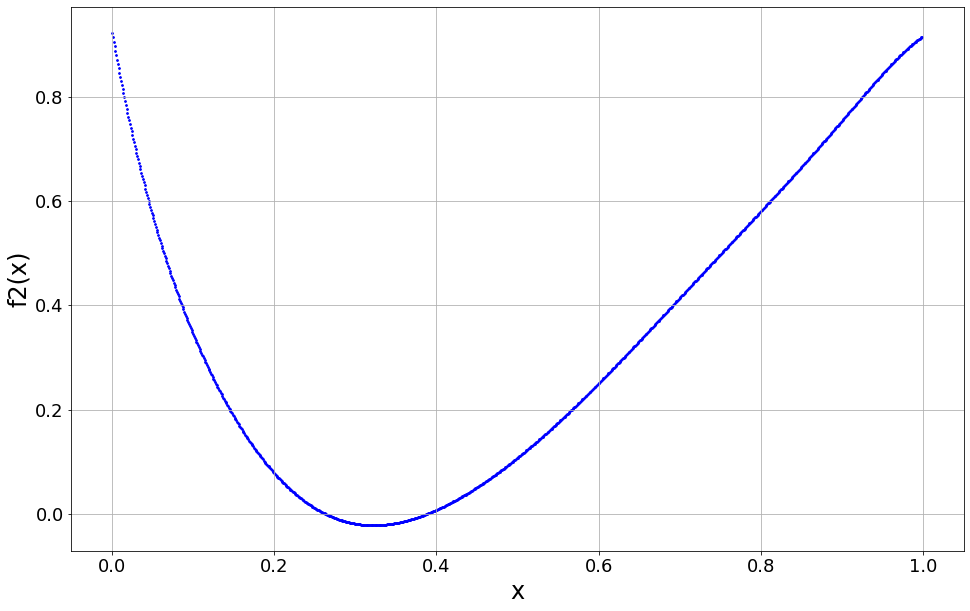

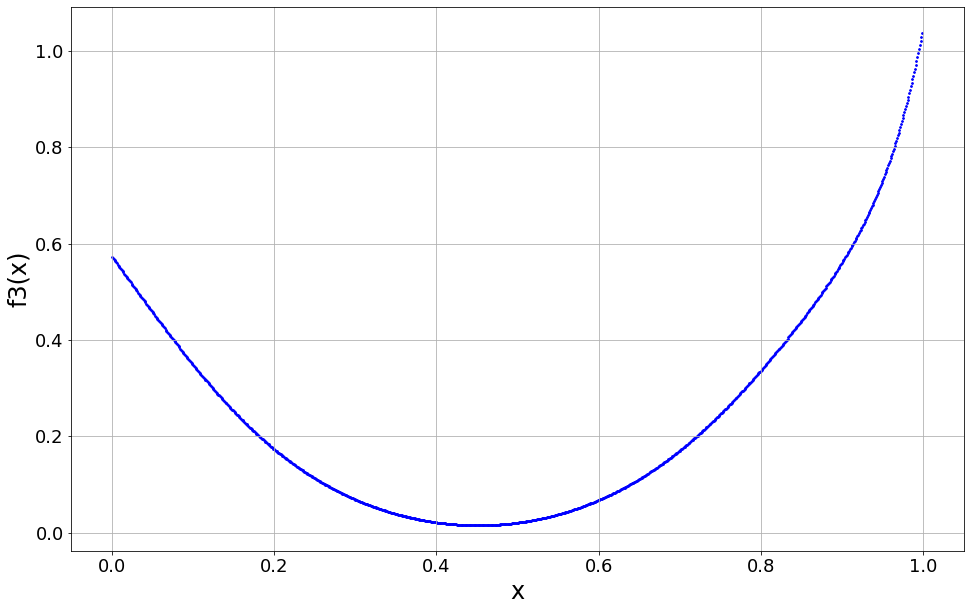

In [13]:
def f1(x, i):
    return models1[i].predict(np.array([[x]]))[0]
f1 = np.vectorize(f1)
x = np.arange(0, 1, 0.001)
for i in range(3):
    plot_for_paper(x, f1(x, i), xlabel='x', ylabel=f'f{i+1}(x)', ticksize=18, fig_size=(16, 10))
    # plot_for_paper(x, f1(x, i), xlabel='x', ylabel=f'f{i+1}(x)', name=f'y = f{i+1}(x)', save=True, ticksize=18)

<span style='font-family:"Times New Roman"'> <span styel=''><font color='navy'>Component function graphs for the 2d-hdmr model</font>

In [14]:
def f2(x, y, i):
    return models2[i].predict(np.array([[x, y]]))[0]
f2 = np.vectorize(f2)

In [15]:
# Determines the maximum and minimum values for each feature. Used to set boundaries for the component functions.
print(max(f2(data_scaled.iloc[:, 0], data_scaled.iloc[:, 1], 0)), min(f2(data_scaled.iloc[:, 0], data_scaled.iloc[:, 1], 0)))
print(max(f2(data_scaled.iloc[:, 0], data_scaled.iloc[:, 2], 1)), min(f2(data_scaled.iloc[:, 0], data_scaled.iloc[:, 2], 1)))
print(max(f2(data_scaled.iloc[:, 1], data_scaled.iloc[:, 2], 2)), min(f2(data_scaled.iloc[:, 1], data_scaled.iloc[:, 2], 2)))

0.6291980743408203 -0.009252548217773438
0.7604961395263672 0.011190414428710938
0.536712646484375 -0.006786346435546875


C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Z contains NaN values. This may result in rendering artifacts.
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Z contains NaN values. This may result in rendering artifacts.
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Z contains NaN values. This may result in rendering artifacts.


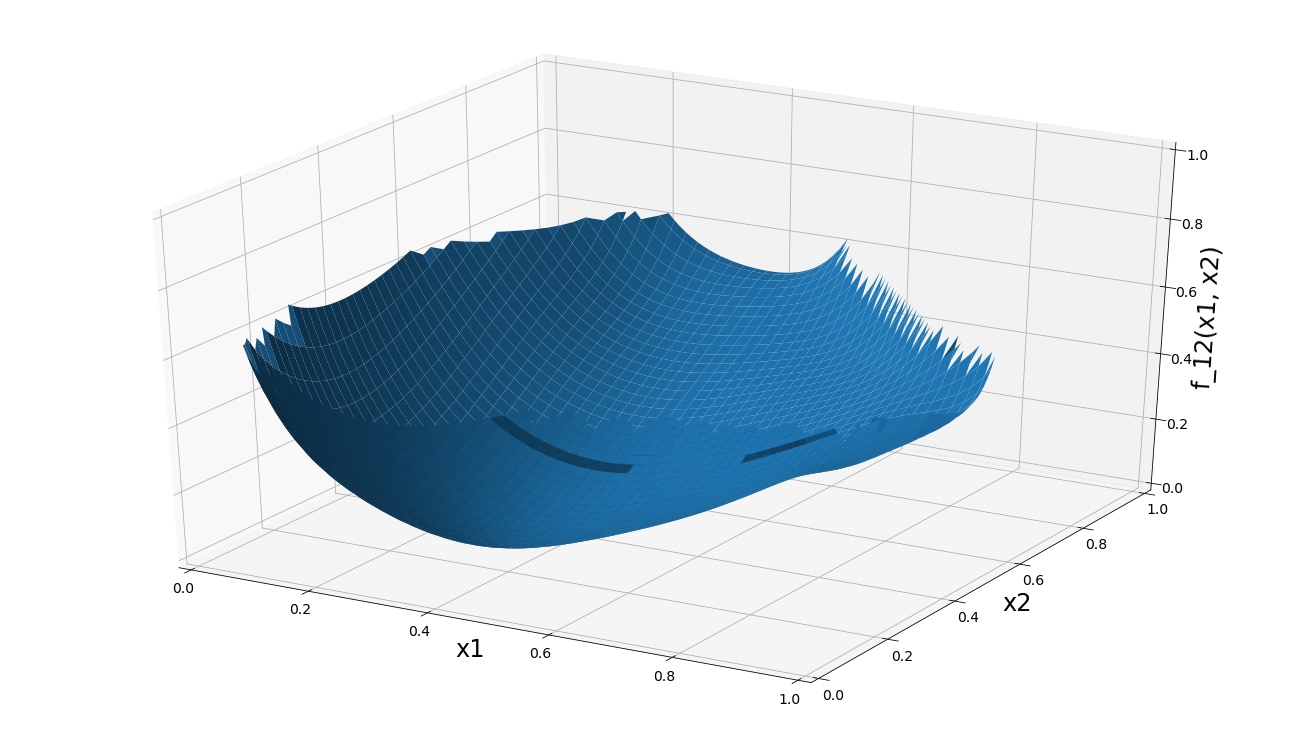

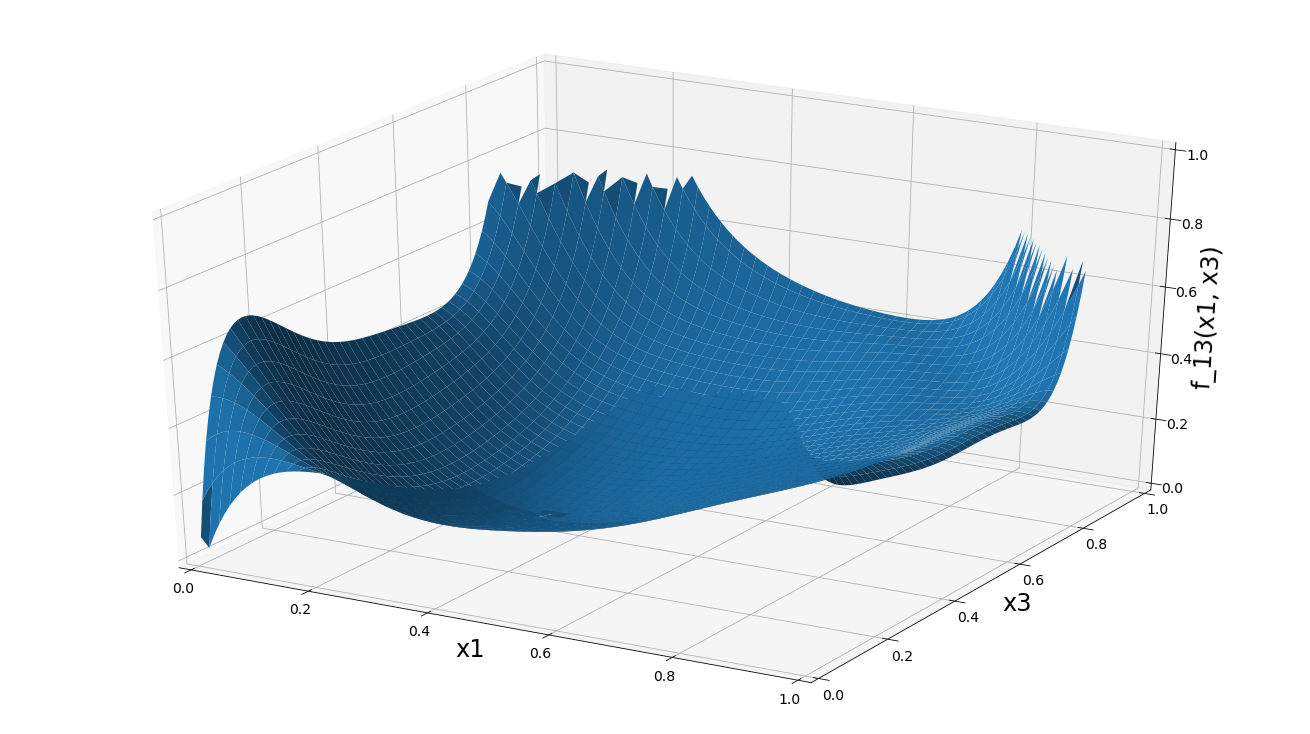

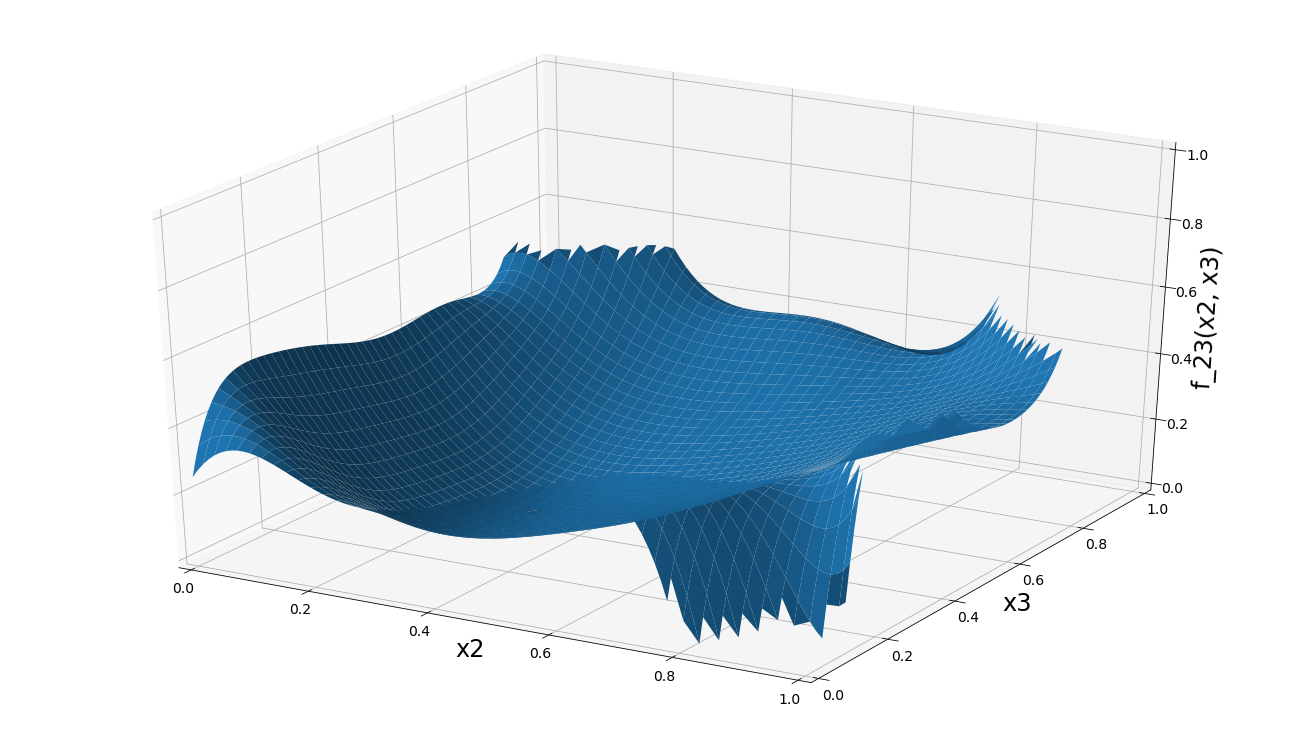

In [16]:
# saves the 2d-hdmr component function graphs.
l = [[1, 2], [1, 3], [2, 3]]
maxs = [0.6291980743408203, 0.7604961395263672, 0.536712646484375]
mins = [-0.009252548217773438, 0.011190414428710938, -0.006786346435546875]
x = y = np.arange(0, 1, 0.01)
x, y = np.meshgrid(x,y)
for i in range(3):
    z = f2(x, y, i)
    for j in range(len(x)):
        for k in range(len(y)):
            if (z[k,j] < mins[i]) or (z[k,j] > maxs[i]):
                z[k,j] = np.nan

    fig = plt.figure(figsize=(18, 10))
    ax = Axes3D(fig)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.set_xlabel(f'x{l[i][0]}', fontsize=24)
    ax.set_ylabel(f'x{l[i][1]}', fontsize=24)
    ax.set_zlabel(f'f_{l[i][0]}{l[i][1]}(x{l[i][0]}, x{l[i][1]})', fontsize=24)
    ax.plot_surface(x, y, z)
#     plt.savefig(f'z=f_{l[i][0]}{l[i][1]}(x{l[i][0]}, x{l[i][1]}).png', dpi=800, bbox_inches='tight')

<span style='font-family:"Times New Roman"'> <span styel=''><font color='navy'>Component function graphs for the 2d*-hdmr model</font>

In [17]:
def f3(x, y, i):
    return models3[i].predict(np.array([[x, y]]))[0]
f3 = np.vectorize(f3)

In [18]:
print(max(f3(data_scaled.iloc[:, 0], data_scaled.iloc[:, 1] + data_scaled.iloc[:, 2], 0)), min(f3(data_scaled.iloc[:, 0], data_scaled.iloc[:, 1] + data_scaled.iloc[:, 2], 0)))
print(max(f3(data_scaled.iloc[:, 0] + data_scaled.iloc[:, 1], data_scaled.iloc[:, 2], 1)), min(f3(data_scaled.iloc[:, 0] + data_scaled.iloc[:, 1], data_scaled.iloc[:, 2], 1)))
print(max(f3(data_scaled.iloc[:, 0] + data_scaled.iloc[:, 2], data_scaled.iloc[:, 1], 2)), min(f3(data_scaled.iloc[:, 0] + data_scaled.iloc[:, 2], data_scaled.iloc[:, 1], 2)))

0.8116469383239746 0.005372524261474609
0.603441596031189 -0.01408994197845459
0.77394700050354 -0.03289604187011719


C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Z contains NaN values. This may result in rendering artifacts.
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Z contains NaN values. This may result in rendering artifacts.
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Z contains NaN values. This may result in rendering artifacts.


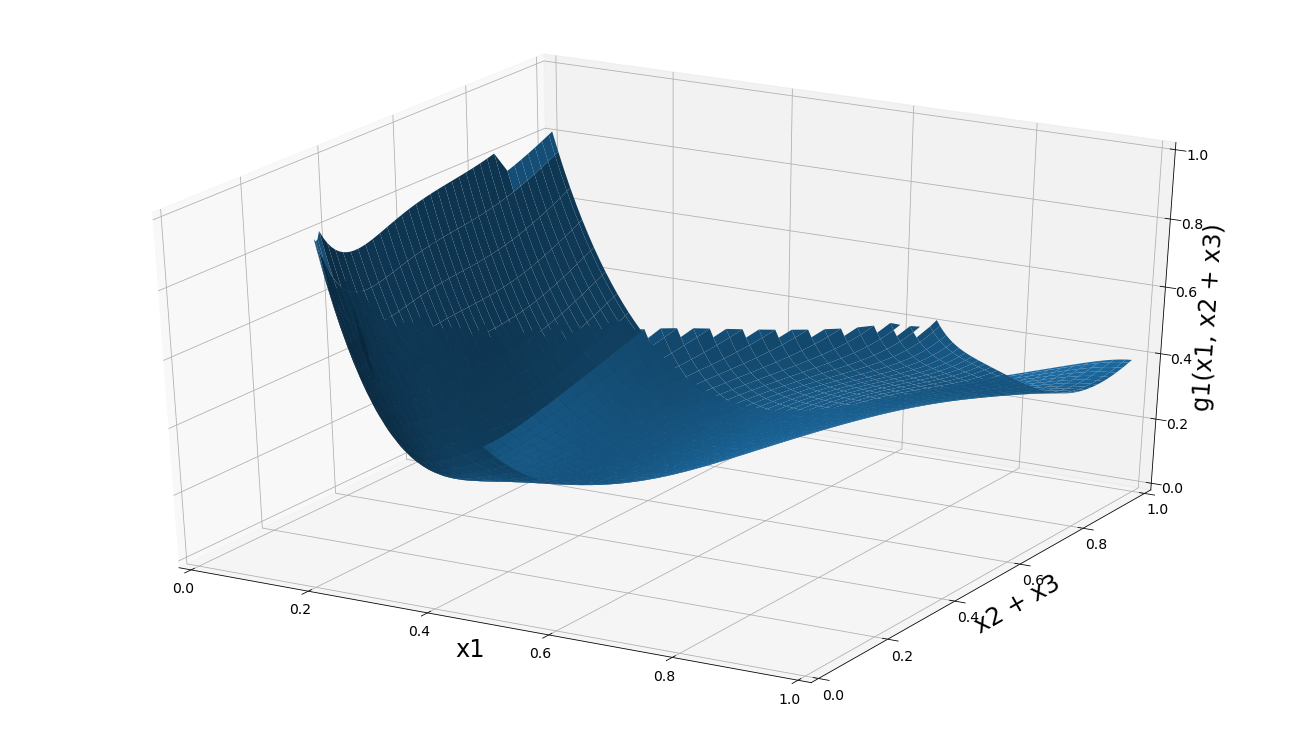

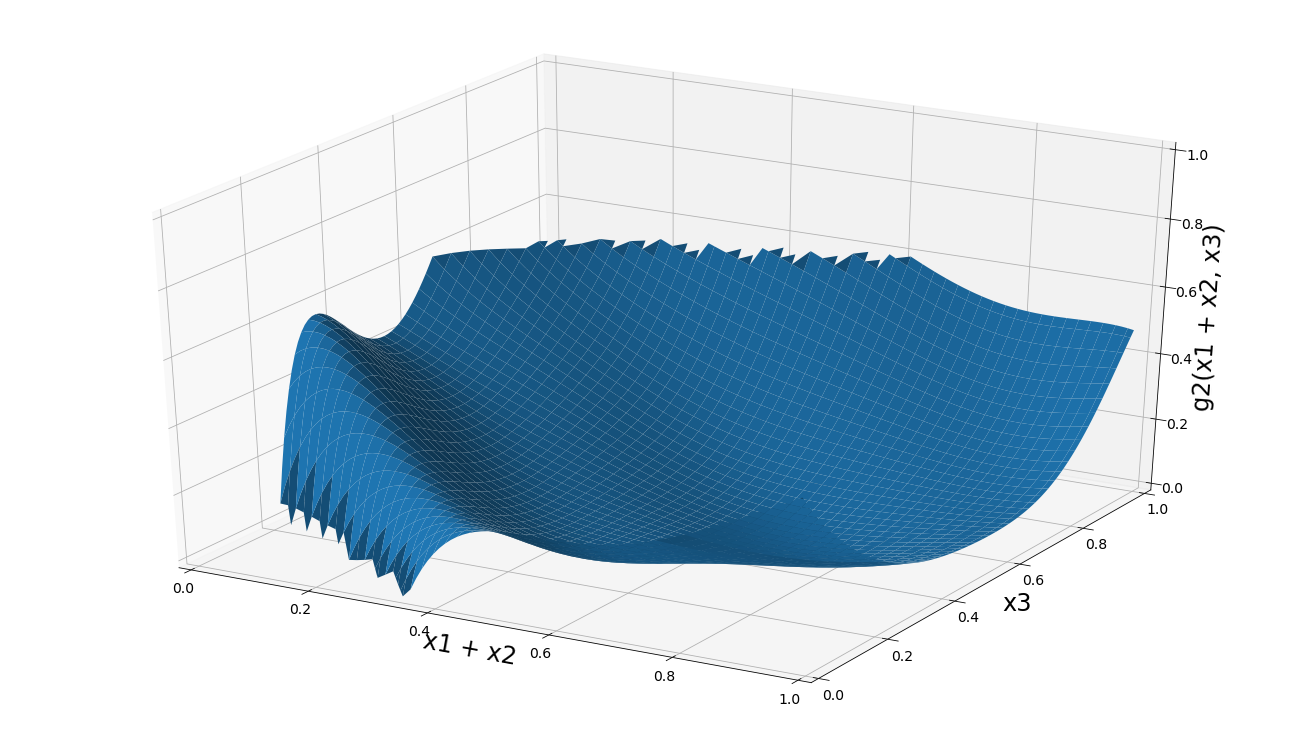

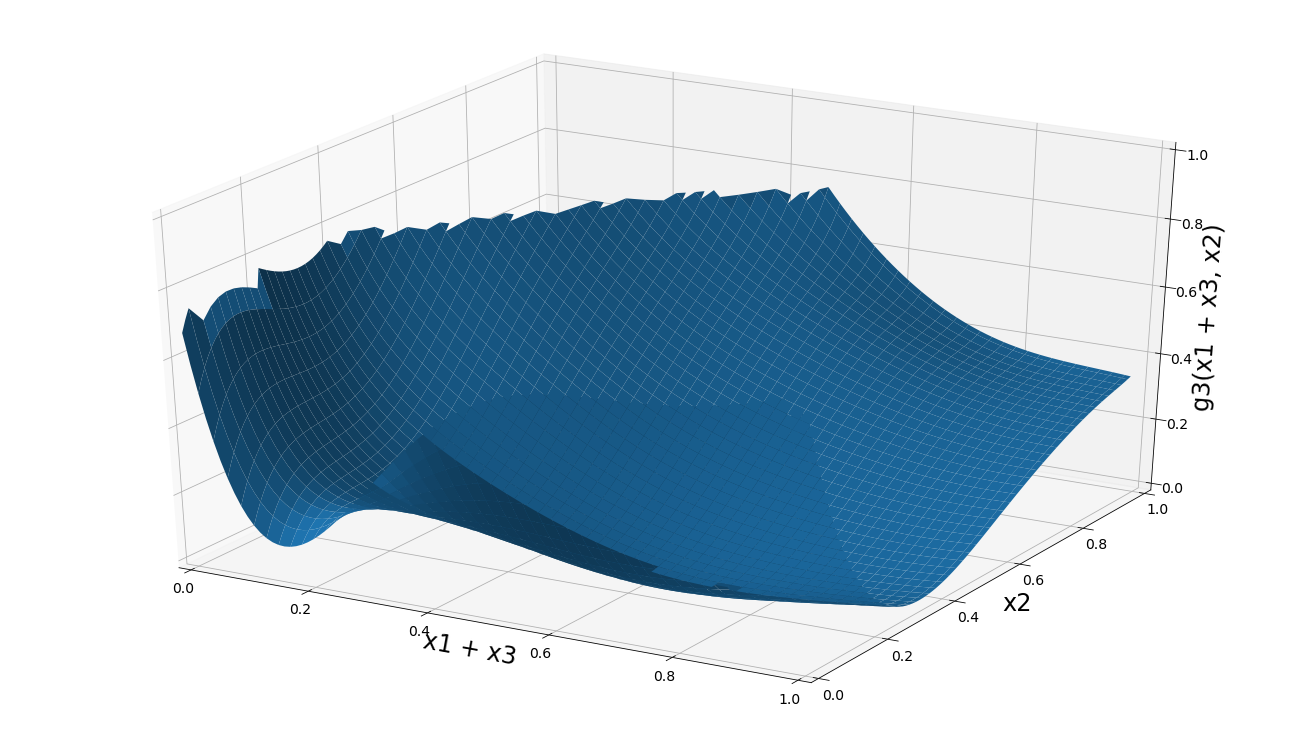

In [19]:
# saves the 2d*-hdmr component function graphs.
l = [['x1', 'x2 + x3'], ['x1 + x2', 'x3'], ['x1 + x3', 'x2']]
maxs = [0.8116469383239746, 0.603441596031189, 0.77394700050354]
mins = [0.005372524261474609, -0.01408994197845459, -0.03289604187011719]
x = y = np.arange(0, 1, 0.01)
x, y = np.meshgrid(x, y)
for i in range(3):
    z = f3(x, y, i)
    for j in range(len(x)):
        for k in range(len(y)):
            if (z[k,j] < mins[i]) or (z[k,j] > maxs[i]):
                z[k,j] = np.nan

    fig = plt.figure(figsize=(18, 10))
    ax = Axes3D(fig)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.set_xlabel(l[i][0], fontsize=24)
    ax.set_ylabel(l[i][1], fontsize=24)
    ax.set_zlabel(f'g{i+1}({l[i][0]}, {l[i][1]})', fontsize=24)
    ax.plot_surface(x, y, z)
#     plt.savefig(f'z=g{i+1}({l[i][0]}, {l[i][1]}).png', dpi=800, bbox_inches='tight')

#### Section 3.2 - Synthetic Dataset

In [20]:
# Below is the list of synthetic functions we will use:

# Sum of the argument function
def f0(*args):
    sumed = 0
    for a in [*args]:
        sumed += a
    
    return sumed
f0 = np.vectorize(f0)

# This function has 4 different possible inverse values in the region [0, 1]
def f1(x, y, z):
    return 0.05 * ((3.5 * (x - 0.5 ))**4 - (5.5 * x - 2.75) ** 2 + 1.6) + y + z
f1 = np.vectorize(f1)
def f2(x, y, z):
    return x**3 + y + z**5
f2 = np.vectorize(f2)
def f3(x, y, z):
    return x + 0.2 * x * y + y + z
f3 = np.vectorize(f3)

Example 1: f(x,y,z) = x + y + z

In [124]:
column_names = []
n = 3
for i in range(n):
    column_names.append(f'a{i}')
data = pd.DataFrame(np.random.rand(10000, 3), columns=column_names)
inputs = [data.iloc[:, i] for i in range(n)]
data['out'] = f0(*inputs)
scale = data['out'].max() - data['out'].min()
trans = data['out'].min()
data['out'] = (data['out'] - trans) / scale
x_train, x_test, y_train, y_test = train_test_split(data, data['out'], train_size=400, test_size=None, random_state=42)

In [125]:
# Trains the 1D hdmr on first 2000 points
d = x_train.shape[1] - 1
matrices, kernels = kernel_matrices(1, d, 0.6)
gpr = RSHDMRGPR(d, matrices, kernels)
gpr.train(x_train[:100], alphas=1e-10)

Training iteration for cycle 1 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 2 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 3 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 4 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 5 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 6 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 7 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 8 has starte

In [126]:
y_pred, y_err = gpr.predict(data.drop(columns=['out']), return_std=True)

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [127]:
print(f'RMSE {math.sqrt(mean_squared_error(data["out"], y_pred))}')

RMSE 0.002668659855061506


In [128]:
# Setting up DataFrame to be imputed.
df_na = x_train[100:].copy()
df_na.iloc[:100, 0] = np.nan
df_na.iloc[100: 200, 1] = np.nan
df_na.iloc[200: , 2] = np.nan

In [129]:
foimp = FirstOrderHDMRImpute(gpr.get_models())

In [130]:
# Appends the output columns for the component functions
foimp.get_yi(df_na)

Int64Index([1060, 3444, 1069, 2205, 9435, 7339, 8208, 7679, 4642, 7683,
            ...
            8322, 5578, 4426,  466, 6265, 5734, 5191, 5390,  860, 7270],
           dtype='int64', length=300)

In [131]:
# Imputes the missing values
foimp.impute(df_na)

Function execution time took 19.264714002609253 seconds.


,a0,a1,a2,out,y_0,y_1,y_2
1060,0.097000,0.289187,0.309807,0.207697,0.041780,0.085172,0.080746
3444,0.090000,0.693992,0.166414,0.292096,0.039380,0.223718,0.028999
1069,0.735000,0.439211,0.610547,0.590576,0.267013,0.138191,0.185373
2205,0.717000,0.199670,0.371271,0.415196,0.260660,0.051673,0.102863
9435,0.885000,0.410022,0.026904,0.425112,0.319042,0.128347,-0.022277
...,...,...,...,...,...,...,...
5734,0.418516,0.381491,0.082000,0.274092,0.153969,0.118525,0.001598
5191,0.195872,0.166974,0.572000,0.288233,0.075612,0.039781,0.172839
5390,0.050363,0.653340,0.863000,0.505121,0.023063,0.209564,0.272495
860,0.122921,0.888659,0.502000,0.490890,0.050243,0.292056,0.148591


RMSE 0.007580697422636046


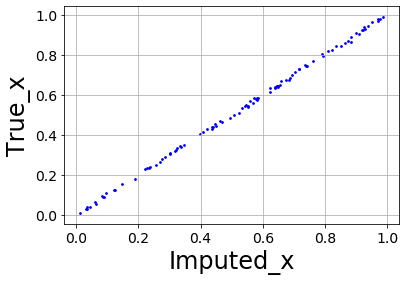

RMSE 0.00799904471623984


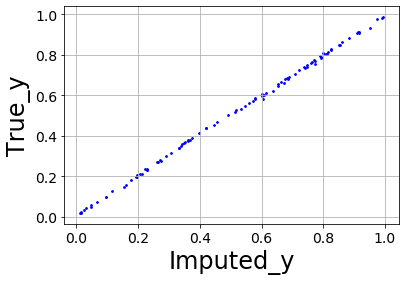

RMSE 0.007480492417202555


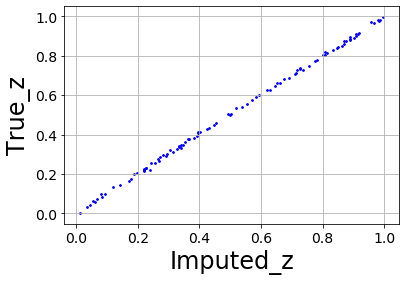

In [132]:
labels = ['x', 'y', 'z']
for i in range(3):
    print(f'RMSE {math.sqrt(mean_squared_error(df_na.iloc[100 * i: 100 * (i + 1), i], x_train.iloc[100*(i+1): 100*(i+2), i]))}')
    plot_for_paper(df_na.iloc[100 * i: 100 * (i + 1), i], x_train.iloc[100*(i+1): 100*(i+2), i], xlabel=f'Imputed_{labels[i]}', ylabel=f'True_{labels[i]}')

In [133]:
# Trains the 1D hdmr on the training set concatenated with the imputed data.
d = x_train.shape[1] - 1
matrices, kernels = kernel_matrices(1, d, 0.6)
gpr = RSHDMRGPR(d, matrices, kernels)
gpr.train(pd.concat([x_train[:100], df_na.iloc[:, :4]]), alphas=1e-10)

Training iteration for cycle 1 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 2 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 3 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 4 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 5 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 6 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 7 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 8 has starte

In [134]:
y_pred, y_err = gpr.predict(data.drop(columns=['out']), return_std=True)

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [135]:
print(f'RMSE {math.sqrt(mean_squared_error(data["out"], y_pred))}')

RMSE 0.0027717144058546123


Example 2: f(x<sub>1</sub>, x<sub>2</sub>, ... , x<sub>15</sub>) = x<sub>1</sub> + x<sub>2</sub> + ... + x<sub>15</sub>

In [170]:
# Generates the 15D data.
column_names = []
n = 15
for i in range(n):
    column_names.append(f'a{i}')
np.random.seed(42)  # Fixes the random seed so the results are always the same.
data = pd.DataFrame(np.random.rand(10000, 15), columns=column_names)
inputs = [data.iloc[:, i] for i in range(n)]
data['out'] = f0(*inputs)
scale = data['out'].max() - data['out'].min()
trans = data['out'].min()
data['out'] = (data['out'] - trans) / scale
x_train, x_test, y_train, y_test = train_test_split(data, data['out'], train_size=300, test_size=None, random_state=42)

In [171]:
# Trains the 1D hdmr on first 200 points
d = x_train.shape[1] - 1
matrices, kernels = kernel_matrices(1, d, 0.6)
gpr = RSHDMRGPR(d, matrices, kernels)
gpr.train(x_train[:200], alphas=1e-10)

Training iteration for cycle 1 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training component function: 4
Training component function: 5
Training component function: 6
Training component function: 7
Training component function: 8
Training component function: 9
Training component function: 10
Training component function: 11
Training component function: 12
Training component function: 13
Training component function: 14
Training component function: 15
Training iteration for cycle 2 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training component function: 4
Training component function: 5
Training component function: 6
Training component function: 7
Training component function: 8
Training component function: 9
Training component function: 10
Training component function: 11
Training component function: 12
Training component function: 13
Training component function: 14
Tr

In [172]:
y_pred, y_err = gpr.predict(data.drop(columns=['out']), return_std=True)

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py

In [173]:
print(f'RMSE {math.sqrt(mean_squared_error(data["out"], y_pred))}')

RMSE 0.014317985987853289


In [174]:
df_na = x_train[200:].copy()
df_na.iloc[:, 0] = np.nan

In [175]:
foimp = FirstOrderHDMRImpute(gpr.get_models())

In [176]:
foimp.get_yi(df_na)
foimp.impute(df_na)

Function execution time took 6.694095849990845 seconds.


,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,...,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12,y_13,y_14
3099,0.950,0.175959,0.745513,0.306888,0.226071,0.557869,0.765125,0.726737,0.233756,0.330502,...,0.046111,0.064566,0.068602,0.002896,0.011008,0.071543,0.055981,0.051054,0.007208,0.064102
6184,0.343,0.275515,0.563927,0.524290,0.432415,0.776180,0.498164,0.978796,0.801812,0.106449,...,0.069389,0.032434,0.090859,0.069035,-0.015332,0.008553,0.036235,0.020503,-0.022347,0.031825
3561,0.750,0.589921,0.660171,0.019466,0.670514,0.388353,0.460214,0.808050,0.523794,0.986871,...,0.022038,0.027502,0.072800,0.039608,0.089422,0.066938,0.056427,0.039377,0.023447,-0.025631
5892,0.240,0.283753,0.007310,0.080278,0.397543,0.939762,0.994799,0.050120,0.830580,0.480258,...,0.093961,0.093015,-0.020071,0.071868,0.029627,0.052375,0.031241,0.086969,0.031714,-0.014065
391,0.438,0.732219,0.233019,0.813142,0.588431,0.210763,0.236720,0.628030,0.829940,0.415628,...,-0.001254,0.001128,0.052018,0.071802,0.020444,0.006351,0.073801,0.047405,0.027841,0.029295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.941,0.141108,0.323845,0.557732,0.003515,0.847278,0.369480,0.723398,0.769298,0.548083,...,0.078339,0.014271,0.068237,0.066174,0.039857,0.066616,0.052746,0.006924,0.071436,0.040561
5191,0.970,0.131844,0.452604,0.454769,0.456334,0.930704,0.327193,0.614273,0.896313,0.050539,...,0.092521,0.008860,0.049128,0.078759,-0.023387,0.072553,0.059796,-0.002760,0.013463,0.005706
5390,0.207,0.845841,0.304221,0.369807,0.801831,0.814177,0.400009,0.553825,0.679210,0.688607,...,0.073628,0.018701,0.036916,0.059579,0.057756,0.041049,0.070105,0.070065,0.075281,-0.001792
860,0.776,0.271484,0.038972,0.847790,0.863867,0.596231,0.574434,0.813120,0.786310,0.890105,...,0.051925,0.040548,0.072839,0.067621,0.082687,0.043509,0.088412,0.093417,-0.011300,0.071194


RMSE 0.10536967550415784


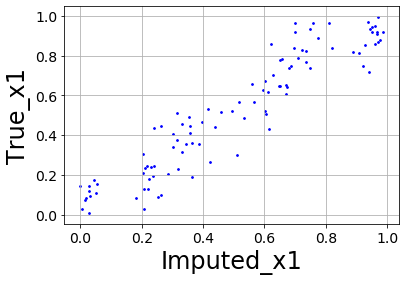

In [177]:
print(f'RMSE {math.sqrt(mean_squared_error(df_na.iloc[:, 0], x_train.iloc[200:, 0]))}')
plot_for_paper(df_na.iloc[:, 0], x_train.iloc[200:, 0], xlabel=f'Imputed_x1', ylabel=f'True_x1')

Example 3: f(x,y,z) = x + y + z With Noise (from a normal distribution) added to the output

In [189]:
column_names = []
n = 3
for i in range(n):
    column_names.append(f'a{i}')
np.random.seed(42)  # Fixes the random seed so the results are always the same.
data = pd.DataFrame(np.random.rand(10000, 3), columns=column_names)
inputs = [data.iloc[:, i] for i in range(n)]
data['out'] = f0(*inputs)
data['out'] = data['out'] + 0.05 * np.random.randn(10000)  # Adds noise generated by a normal distribution with mean=0 and standard deviation=0.05
scale = data['out'].max() - data['out'].min()
trans = data['out'].min()
data['out'] = (data['out'] - trans) / scale
x_train, x_test, y_train, y_test = train_test_split(data, data['out'], train_size=300, test_size=None, random_state=42)

In [190]:
# Trains the 1D hdmr on first 2000 points
d = x_train.shape[1] - 1
matrices, kernels = kernel_matrices(1, d, 0.6)
gpr = RSHDMRGPR(d, matrices, kernels)
gpr.train(x_train[:200], alphas=1e-10)

Training iteration for cycle 1 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 2 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 3 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 4 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 5 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 6 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 7 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 8 has starte

In [191]:
y_pred, y_err = gpr.predict(data.drop(columns=['out']), return_std=True)

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [192]:
print(f'RMSE {math.sqrt(mean_squared_error(data["out"], y_pred))}')

RMSE 0.01776674717514124


In [193]:
df_na = x_train[200:].copy()
df_na.iloc[:, 0] = np.nan

In [194]:
foimp = FirstOrderHDMRImpute(gpr.get_models())
foimp.get_yi(df_na)
foimp.impute(df_na)

Function execution time took 5.945099592208862 seconds.


,a0,a1,a2,out,y_0,y_1,y_2
3099,0.822,0.943428,0.098495,0.605783,0.282382,0.308625,0.014776
6184,0.529,0.490203,0.361807,0.444268,0.182066,0.151085,0.111117
3561,0.656,0.439448,0.297847,0.450129,0.223536,0.135607,0.090986
5892,0.758,0.085398,0.626503,0.465955,0.257371,0.015516,0.193068
391,0.269,0.634006,0.539985,0.465640,0.098571,0.206527,0.160542
...,...,...,...,...,...,...,...
5734,0.431,0.381491,0.098209,0.282685,0.148597,0.119381,0.014706
5191,0.093,0.166974,0.575577,0.251972,0.036750,0.041709,0.173513
5390,0.002,0.653340,0.851426,0.480423,-0.000142,0.213998,0.266567
860,0.120,0.888659,0.503084,0.479420,0.046159,0.284925,0.148336


RMSE 0.04914385280567974


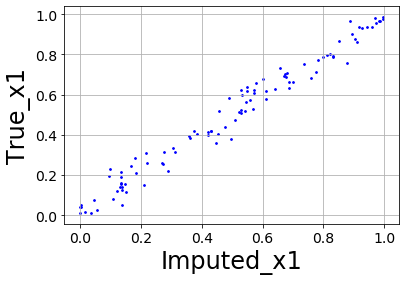

In [195]:
print(f'RMSE {math.sqrt(mean_squared_error(df_na.iloc[:, 0], x_train.iloc[200:, 0]))}')
plot_for_paper(df_na.iloc[:, 0], x_train.iloc[200:, 0], xlabel=f'Imputed_x1', ylabel=f'True_x1')
# plot_for_paper(df_na.iloc[:, 0], x_train.iloc[200:, 0], xlabel=f'Imputed_x1', ylabel=f'True_x1', name=f'Imputed_x1.png', save=True)

Example 4: f(x,y,z) = x + y + z With Uneven Distribution for the features

In [208]:
column_names = []
n = 3
for i in range(n):
    column_names.append(f'a{i}')
np.random.seed(42)  # Fixes the random seed so the results are always the same.
# Generates data with bad distribution.
data = pd.DataFrame(np.concatenate([np.random.rand(5000, 3), 0.01 * np.random.randn(10000, 3) + 0.1]), columns=column_names)
inputs = [data.iloc[:, i] for i in range(n)]
data['out'] = f0(*inputs)
scale = data['out'].max() - data['out'].min()
trans = data['out'].min()
data['out'] = (data['out'] - trans) / scale
x_train, x_test, y_train, y_test = train_test_split(data, data['out'], train_size=300, test_size=None, random_state=42)

In [209]:
# Trains the 1D hdmr on first 2000 points
d = x_train.shape[1] - 1
matrices, kernels = kernel_matrices(1, d, 0.6)
gpr = RSHDMRGPR(d, matrices, kernels)
gpr.train(x_train[:200], alphas=1e-10)

Training iteration for cycle 1 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 2 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 3 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 4 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 5 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 6 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 7 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 8 has starte

In [210]:
y_pred, y_err = gpr.predict(data.drop(columns=['out']), return_std=True)

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [211]:
print(f'RMSE {math.sqrt(mean_squared_error(data["out"], y_pred))}')

RMSE 0.005500712962463071


In [212]:
df_na = x_train[200:].copy()
df_na.iloc[:, 0] = np.nan

In [214]:
foimp = FirstOrderHDMRImpute(gpr.get_models())
foimp.get_yi(df_na)
foimp.impute(df_na)

Function execution time took 6.030868291854858 seconds.


,a0,a1,a2,out,y_0,y_1,y_2
14605,0.100,0.095966,0.081369,0.051562,0.021804,0.017824,0.011934
995,0.929,0.051669,0.504796,0.515360,0.351837,0.005109,0.158413
10173,0.118,0.096873,0.110376,0.068839,0.028250,0.018147,0.022442
4297,0.534,0.167368,0.978457,0.567533,0.186043,0.047815,0.333675
161,0.603,0.584314,0.901158,0.735100,0.214633,0.209701,0.310767
...,...,...,...,...,...,...,...
5191,0.093,0.107571,0.106899,0.062841,0.019427,0.022115,0.021299
13418,0.114,0.117338,0.117405,0.077336,0.026694,0.025957,0.024685
5390,0.099,0.094726,0.115429,0.062810,0.021362,0.017385,0.024063
860,0.134,0.888659,0.503084,0.512066,0.034919,0.319330,0.157817


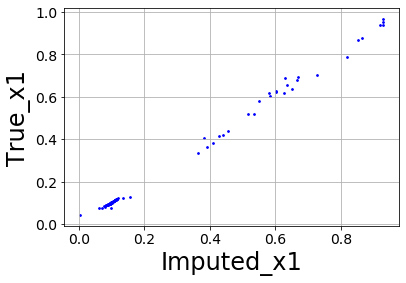

In [215]:
print(f'RMSE {math.sqrt(mean_squared_error(df_na.iloc[:, 0], x_train.iloc[200:, 0]))}')
plot_for_paper(df_na.iloc[:, 0], x_train.iloc[200:, 0], xlabel=f'Imputed_x1', ylabel=f'True_x1')
# plot_for_paper(df_na.iloc[:, 0], x_train.iloc[200:, 0], xlabel=f'Imputed_x1', ylabel=f'True_x1', name=f'Imputed_x1.png', save=True)

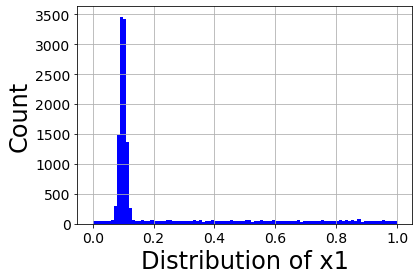

In [216]:
# Plots the distribution of the first feature
plt.figure()
data.iloc[:, 0].hist(bins=100, color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Distribution of x1', size=24)
plt.ylabel('Count', size=24)
plt.show()
# plt.savefig('hist.png', dpi=800, bbox_inches='tight')

Example 5: f(x, y, z) = x^3 + y + z^5

In [225]:
column_names = []
n = 3
for i in range(n):
    column_names.append(f'a{i}')
np.random.seed(42)  # Fixes the random seed so the results are always the same.
data = pd.DataFrame(np.random.rand(10000, 3), columns=column_names)
inputs = [data.iloc[:, i] for i in range(n)]
data['out'] = f1(*inputs)
scale = data['out'].max() - data['out'].min()
trans = data['out'].min()
data['out'] = (data['out'] - trans) / scale
x_train, x_test, y_train, y_test = train_test_split(data, data['out'], train_size=400, test_size=None, random_state=42)

In [226]:
# Trains the 1D hdmr on first 2000 points
d = x_train.shape[1] - 1
matrices, kernels = kernel_matrices(1, d, 0.6)
gpr = RSHDMRGPR(d, matrices, kernels)
gpr.train(x_train[:100], alphas=1e-10)

Training iteration for cycle 1 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 2 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 3 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 4 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 5 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 6 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 7 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 8 has starte

In [227]:
y_pred, y_err = gpr.predict(data.drop(columns=['out']), return_std=True)

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [228]:
print(f'RMSE {math.sqrt(mean_squared_error(data["out"], y_pred))}')

RMSE 0.004709554906655107


In [229]:
df_na = x_train[100:].copy()
df_na.iloc[:100, 0] = np.nan
df_na.iloc[100: 200, 1] = np.nan
df_na.iloc[200: , 2] = np.nan

In [230]:
foimp = FirstOrderHDMRImpute(gpr.get_models())

In [231]:
foimp.get_yi(df_na)

Int64Index([1060, 3444, 1069, 2205, 9435, 7339, 8208, 7679, 4642, 7683,
            ...
            8322, 5578, 4426,  466, 6265, 5734, 5191, 5390,  860, 7270],
           dtype='int64', length=300)

In [232]:
foimp.impute(df_na)

Function execution time took 20.651582956314087 seconds.


,a0,a1,a2,out,y_0,y_1,y_2
1060,0.135000,0.289187,0.309807,0.281181,0.156679,0.064281,0.060220
3444,0.078000,0.693992,0.166414,0.414240,0.173691,0.251904,-0.011354
1069,0.143000,0.439211,0.610547,0.494056,0.155343,0.136337,0.202376
2205,0.125000,0.199670,0.371271,0.266834,0.158608,0.017619,0.090607
9435,0.110000,0.410022,0.026904,0.203586,0.162201,0.123147,-0.081762
...,...,...,...,...,...,...,...
5734,0.418516,0.381491,0.079000,0.246430,0.186440,0.109918,-0.049928
5191,0.195872,0.166974,0.574000,0.341079,0.154377,0.001082,0.185620
5390,0.050363,0.653340,0.871000,0.744388,0.187846,0.232540,0.324002
860,0.122921,0.888659,0.505000,0.659148,0.159871,0.345521,0.153756


In [233]:
labels = ['x', 'y', 'z']
for i in range(3):
    print(f'RMSE {math.sqrt(mean_squared_error(df_na.iloc[100 * i: 100 * (i + 1), i], x_train.iloc[100*(i+1): 100*(i+2), i]))}')
#     plot_for_paper(df_na.iloc[100 * i: 100 * (i + 1), i], x_train.iloc[100*(i+1): 100*(i+2), i], xlabel=f'Imputed_{labels[i]}', ylabel=f'True_{labels[i]}', 
#                    name=f'Imputed_{labels[i]}', save=True)

RMSE 0.5259209270464678
RMSE 0.010127431071149691
RMSE 0.009463036879423226


Example 6: f(x, y, z) = x + 0.2xy + y + z

In [242]:
column_names = []
n = 3
for i in range(n):
    column_names.append(f'a{i}')
np.random.seed(42)  # Fixes the random seed so the results are always the same.
# data = pd.DataFrame(np.concatenate([np.random.rand(5000, 3), 0.01 * np.random.randn(10000, 3) + 0.1]), columns=column_names)
data = pd.DataFrame(np.random.rand(10000, 3), columns=column_names)
inputs = [data.iloc[:, i] for i in range(n)]
data['out'] = f3(*inputs)
# data['out'] = data['out'] + 0.05 * np.random.randn(10000)
scale = data['out'].max() - data['out'].min()
trans = data['out'].min()
data['out'] = (data['out'] - trans) / scale
x_train, x_test, y_train, y_test = train_test_split(data, data['out'], train_size=400, test_size=None, random_state=42)

In [243]:
# Trains the 1D hdmr on first 2000 points
d = x_train.shape[1] - 1
matrices, kernels = kernel_matrices(1, d, 0.6)
gpr = RSHDMRGPR(d, matrices, kernels)
gpr.train(x_train[:100], alphas=1e-10)

Training iteration for cycle 1 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 2 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 3 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 4 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 5 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 6 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 7 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training iteration for cycle 8 has starte

In [244]:
y_pred, y_err = gpr.predict(data.drop(columns=['out']), return_std=True)

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [245]:
print(f'RMSE {math.sqrt(mean_squared_error(data["out"], y_pred))}')

RMSE 0.006743294318193248


In [246]:
df_na = x_train[100:].copy()
df_na.iloc[:100, 0] = np.nan
df_na.iloc[100: 200, 1] = np.nan
df_na.iloc[200: , 2] = np.nan

In [247]:
foimp = FirstOrderHDMRImpute(gpr.get_models())

In [248]:
foimp.get_yi(df_na)

Int64Index([1060, 3444, 1069, 2205, 9435, 7339, 8208, 7679, 4642, 7683,
            ...
            8322, 5578, 4426,  466, 6265, 5734, 5191, 5390,  860, 7270],
           dtype='int64', length=300)

In [249]:
foimp.impute(df_na)

Function execution time took 17.87020254135132 seconds.


,a0,a1,a2,out,y_0,y_1,y_2
1060,0.108000,0.289187,0.309807,0.196426,0.036219,0.079071,0.081137
3444,0.086000,0.693992,0.166414,0.277434,0.027476,0.220820,0.029139
1069,0.734000,0.439211,0.610547,0.574553,0.264394,0.132312,0.177846
2205,0.696000,0.199670,0.371271,0.398234,0.250167,0.045669,0.102398
9435,0.874000,0.410022,0.026904,0.421996,0.313073,0.122205,-0.013282
...,...,...,...,...,...,...,...
5734,0.418516,0.381491,0.088000,0.267021,0.147221,0.112217,0.007583
5191,0.195872,0.166974,0.586000,0.271901,0.068513,0.033219,0.170170
5390,0.050363,0.653340,0.854000,0.475037,0.012148,0.206112,0.256777
860,0.122921,0.888659,0.473000,0.466737,0.040988,0.291197,0.134553


RMSE 0.01879093528502654


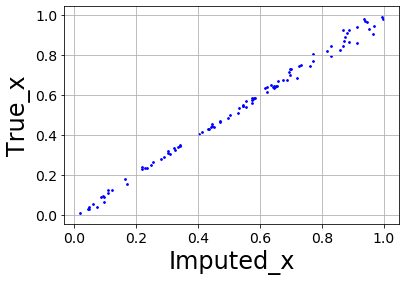

RMSE 0.017235478035511894


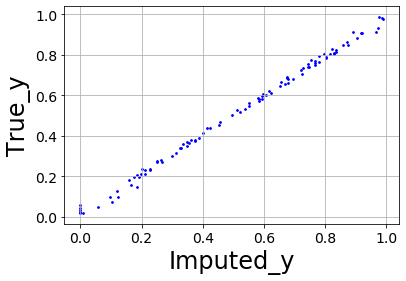

RMSE 0.02168689495367503


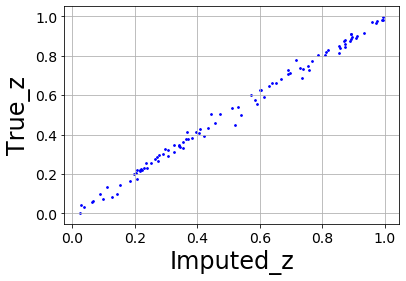

In [250]:
labels = ['x', 'y', 'z']
for i in range(3):
    print(f'RMSE {math.sqrt(mean_squared_error(df_na.iloc[100 * i: 100 * (i + 1), i], x_train.iloc[100*(i+1): 100*(i+2), i]))}')
    plot_for_paper(df_na.iloc[100 * i: 100 * (i + 1), i], x_train.iloc[100*(i+1): 100*(i+2), i], xlabel=f'Imputed_{labels[i]}', ylabel=f'True_{labels[i]}')
#     plot_for_paper(df_na.iloc[100 * i: 100 * (i + 1), i], x_train.iloc[100*(i+1): 100*(i+2), i], xlabel=f'Imputed_{labels[i]}', ylabel=f'True_{labels[i]}', 
#                    name=f'Imputed_{labels[i]}', save=True)

#### Section 3.3 -- Example from Quantitative Finance

In [264]:
df_finance = pd.read_csv('rshdmrgpr/datasets/financial.csv')
df_finance = df_finance.rename(columns={'^GSPC': 'out'})
cols = [col for col in df_finance.columns if col != 'out'] + ['out']
df_finance = df_finance[cols]

In [265]:
data_summary(df_finance)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3927 entries, 0 to 3926
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CPI       3927 non-null   float64
 1   ^IRX      3927 non-null   float64
 2   GLD       3927 non-null   float64
 3   HUC.TO    3927 non-null   float64
 4   AGG       3927 non-null   float64
 5   ^VIX      3927 non-null   float64
 6   ^N225     3927 non-null   float64
 7   ^GDAXI    3927 non-null   float64
 8   ^IXIC     3927 non-null   float64
 9   CADUSD=X  3927 non-null   float64
 10  JPYUSD=X  3927 non-null   float64
 11  USDEUR=X  3927 non-null   float64
 12  USDCNY=X  3927 non-null   float64
 13  M2        3927 non-null   float64
 14  out       3927 non-null   float64
dtypes: float64(15)
memory usage: 460.3 KB

Index         128
CPI         31416
^IRX        31416
GLD         31416
HUC.TO      31416
AGG         31416
^VIX        31416
^N225       31416
^GDAXI      31416
^IXIC       31416
CADUSD

In [266]:
df_finance.corr()

,CPI,^IRX,GLD,HUC.TO,AGG,^VIX,^N225,^GDAXI,^IXIC,CADUSD=X,JPYUSD=X,USDEUR=X,USDCNY=X,M2,out
CPI,1.000000,0.751786,-0.079155,-0.694704,0.377789,-0.352083,0.863191,0.897056,0.888830,-0.754783,-0.631979,0.695787,0.315066,0.865202,0.923076
^IRX,0.751786,1.000000,-0.185967,-0.496567,-0.103625,-0.197115,0.690325,0.651377,0.735784,-0.578565,-0.408020,0.452702,0.510839,0.635846,0.743467
GLD,-0.079155,-0.185967,1.000000,0.297826,0.513898,0.323361,-0.415465,-0.344798,-0.119169,0.446256,0.666869,-0.314100,-0.071315,-0.084999,-0.186922
HUC.TO,-0.694704,-0.496567,0.297826,1.000000,-0.407461,-0.018465,-0.795348,-0.771835,-0.775763,0.937069,0.731533,-0.896541,-0.527804,-0.838030,-0.775026
AGG,0.377789,-0.103625,0.513898,-0.407461,1.000000,0.153394,0.196764,0.261914,0.384452,-0.282884,-0.096777,0.408241,0.130430,0.487477,0.354258
^VIX,-0.352083,-0.197115,0.323361,-0.018465,0.153394,1.000000,-0.270949,-0.381582,-0.114516,0.079508,0.296445,-0.101815,0.215643,-0.058318,-0.211591
^N225,0.863191,0.690325,-0.415465,-0.795348,0.196764,-0.270949,1.000000,0.968564,0.925783,-0.895107,-0.883208,0.760805,0.361402,0.897100,0.953616
^GDAXI,0.897056,0.651377,-0.344798,-0.771835,0.261914,-0.381582,0.968564,1.000000,0.905273,-0.859375,-0.836991,0.753889,0.309368,0.884163,0.943886
^IXIC,0.888830,0.735784,-0.119169,-0.775763,0.384452,-0.114516,0.925783,0.905273,1.000000,-0.840608,-0.695558,0.716111,0.509207,0.971749,0.989130
CADUSD=X,-0.754783,-0.578565,0.446256,0.937069,-0.282884,0.079508,-0.895107,-0.859375,-0.840608,1.000000,0.849995,-0.898207,-0.495202,-0.874488,-0.856308


In [267]:
scale = df_finance['out'].max() - df_finance['out'].min()
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_finance)
data_scaled = pd.DataFrame(scaler.transform(df_finance), columns=cols)

In [268]:
x_train, x_test, y_train, y_test = train_test_split(data_scaled, data_scaled['out'], train_size=500, test_size=None, random_state=42)

In [269]:
# Creates and Trains the 1d-hdmr model
d = data_scaled.shape[1] - 1
matrices1, kernels1 = kernel_matrices(1, d, 0.6)
hdmr1 = RSHDMRGPR(len(matrices1), matrices1, kernels1)
hdmr1.train(x_train, alphas=1e-6)

Training iteration for cycle 1 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training component function: 4
Training component function: 5
Training component function: 6
Training component function: 7
Training component function: 8
Training component function: 9
Training component function: 10
Training component function: 11
Training component function: 12
Training component function: 13
Training component function: 14
Training iteration for cycle 2 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training component function: 4
Training component function: 5
Training component function: 6
Training component function: 7
Training component function: 8
Training component function: 9
Training component function: 10
Training component function: 11
Training component function: 12
Training component function: 13
Training component function: 14
Training iteration for cycle 3 has

In [270]:
y_pred1 = hdmr1.predict(data_scaled.drop(columns=['out']))

RMSE 31.607845733575118


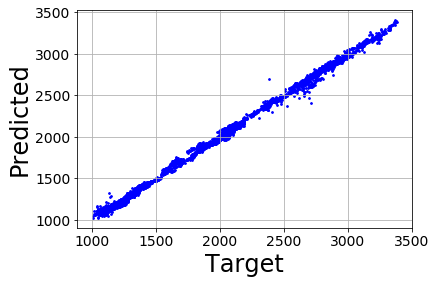

In [271]:
print(f'RMSE {math.sqrt(mean_squared_error(df_finance["out"], y_pred1 * scale + df_finance["out"].min()))}')
plot_for_paper(df_finance['out'], y_pred1 * scale + df_finance['out'].min(), xlabel='Target', ylabel='Predicted')
# plot_for_paper(df_finance['out'], y_pred1 * scale + df_finance['out'].min(), xlabel='Target', ylabel='Predicted', name='1dhdmr.png', save=True)

In [272]:
# Creates and trains the 2d-hdmr model
d = data_scaled.shape[1] - 1
matrices2, kernels2 = kernel_matrices(2, d, 0.6)
hdmr2 = RSHDMRGPR(len(matrices2), matrices2, kernels2)
hdmr2.train(x_train, alphas=1e-6)

Training iteration for cycle 1 has started.
Training component function: 1
Training component function: 2
Training component function: 3
Training component function: 4
Training component function: 5
Training component function: 6
Training component function: 7
Training component function: 8
Training component function: 9
Training component function: 10
Training component function: 11
Training component function: 12
Training component function: 13
Training component function: 14
Training component function: 15
Training component function: 16
Training component function: 17
Training component function: 18
Training component function: 19
Training component function: 20
Training component function: 21
Training component function: 22
Training component function: 23
Training component function: 24
Training component function: 25
Training component function: 26
Training component function: 27
Training component function: 28
Training component function: 29
Training component function: 30
Train

In [273]:
y_pred2 = hdmr2.predict(data_scaled.drop(columns=['out']))

RMSE 14.73492144679226


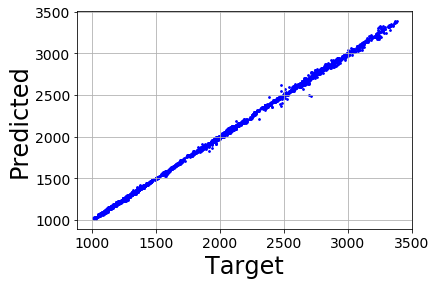

In [274]:
print(f'RMSE {math.sqrt(mean_squared_error(df_finance["out"], y_pred2 * scale + df_finance["out"].min()))}')
plot_for_paper(df_finance['out'], y_pred2 * scale + df_finance['out'].min(), xlabel='Target', ylabel='Predicted', name='2dhdmr.png', save=True)

In [275]:
d = data_scaled.shape[1] - 1
matricesf, kernelsf = kernel_matrices(d, d, 0.6)
hdmrf = RSHDMRGPR(len(matricesf), matricesf, kernelsf)
hdmrf.train(x_train, alphas=1e-6, cycles=1)

Training iteration for cycle 1 has started.
Training component function: 1
Training completed.


In [276]:
y_predf = hdmrf.predict(data_scaled.drop(columns=['out']))

RMSE 16.695603488188954


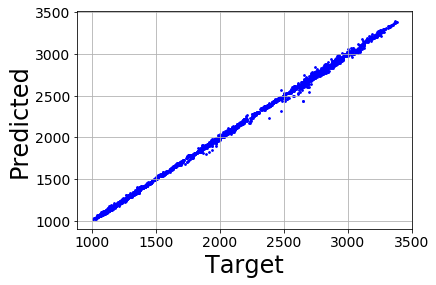

In [277]:
print(f'RMSE {math.sqrt(mean_squared_error(df_finance["out"], y_predf * scale + df_finance["out"].min()))}')
plot_for_paper(df_finance['out'], y_predf * scale + df_finance['out'].min(), xlabel='Target', ylabel='Predicted')
# plot_for_paper(df_finance['out'], y_predf * scale + df_finance['out'].min(), xlabel='Target', ylabel='Predicted', name='fulldhdmr.png', save=True)

In [ ]:
# 3d-hdmr model (training takes a while)
d = data_scaled.shape[1] - 1
matrices3, kernels3 = kernel_matrices(3, d, 0.7)
hdmr3 = RSHDMRGPR(len(matrices3), matrices3, kernels3)
hdmr3.train(x_train, alphas=1e-7)

In [37]:
y_pred3 = hdmr3.predict(data_scaled.drop(columns=['out']))

RMSE 32.91166019102686


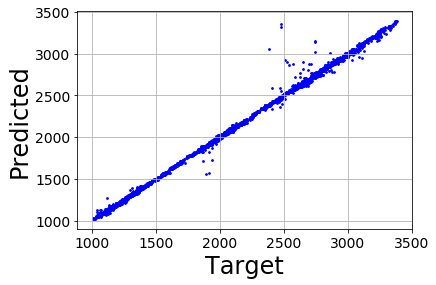

In [38]:
print(f'RMSE {math.sqrt(mean_squared_error(df_finance["out"], y_pred3 * scale + df_finance["out"].min()))}')
plot_for_paper(df_finance['out'], y_pred3 * scale + df_finance['out'].min(), xlabel='Target', ylabel='Predicted')

In [53]:
data_scaled.shape

(3927, 15)

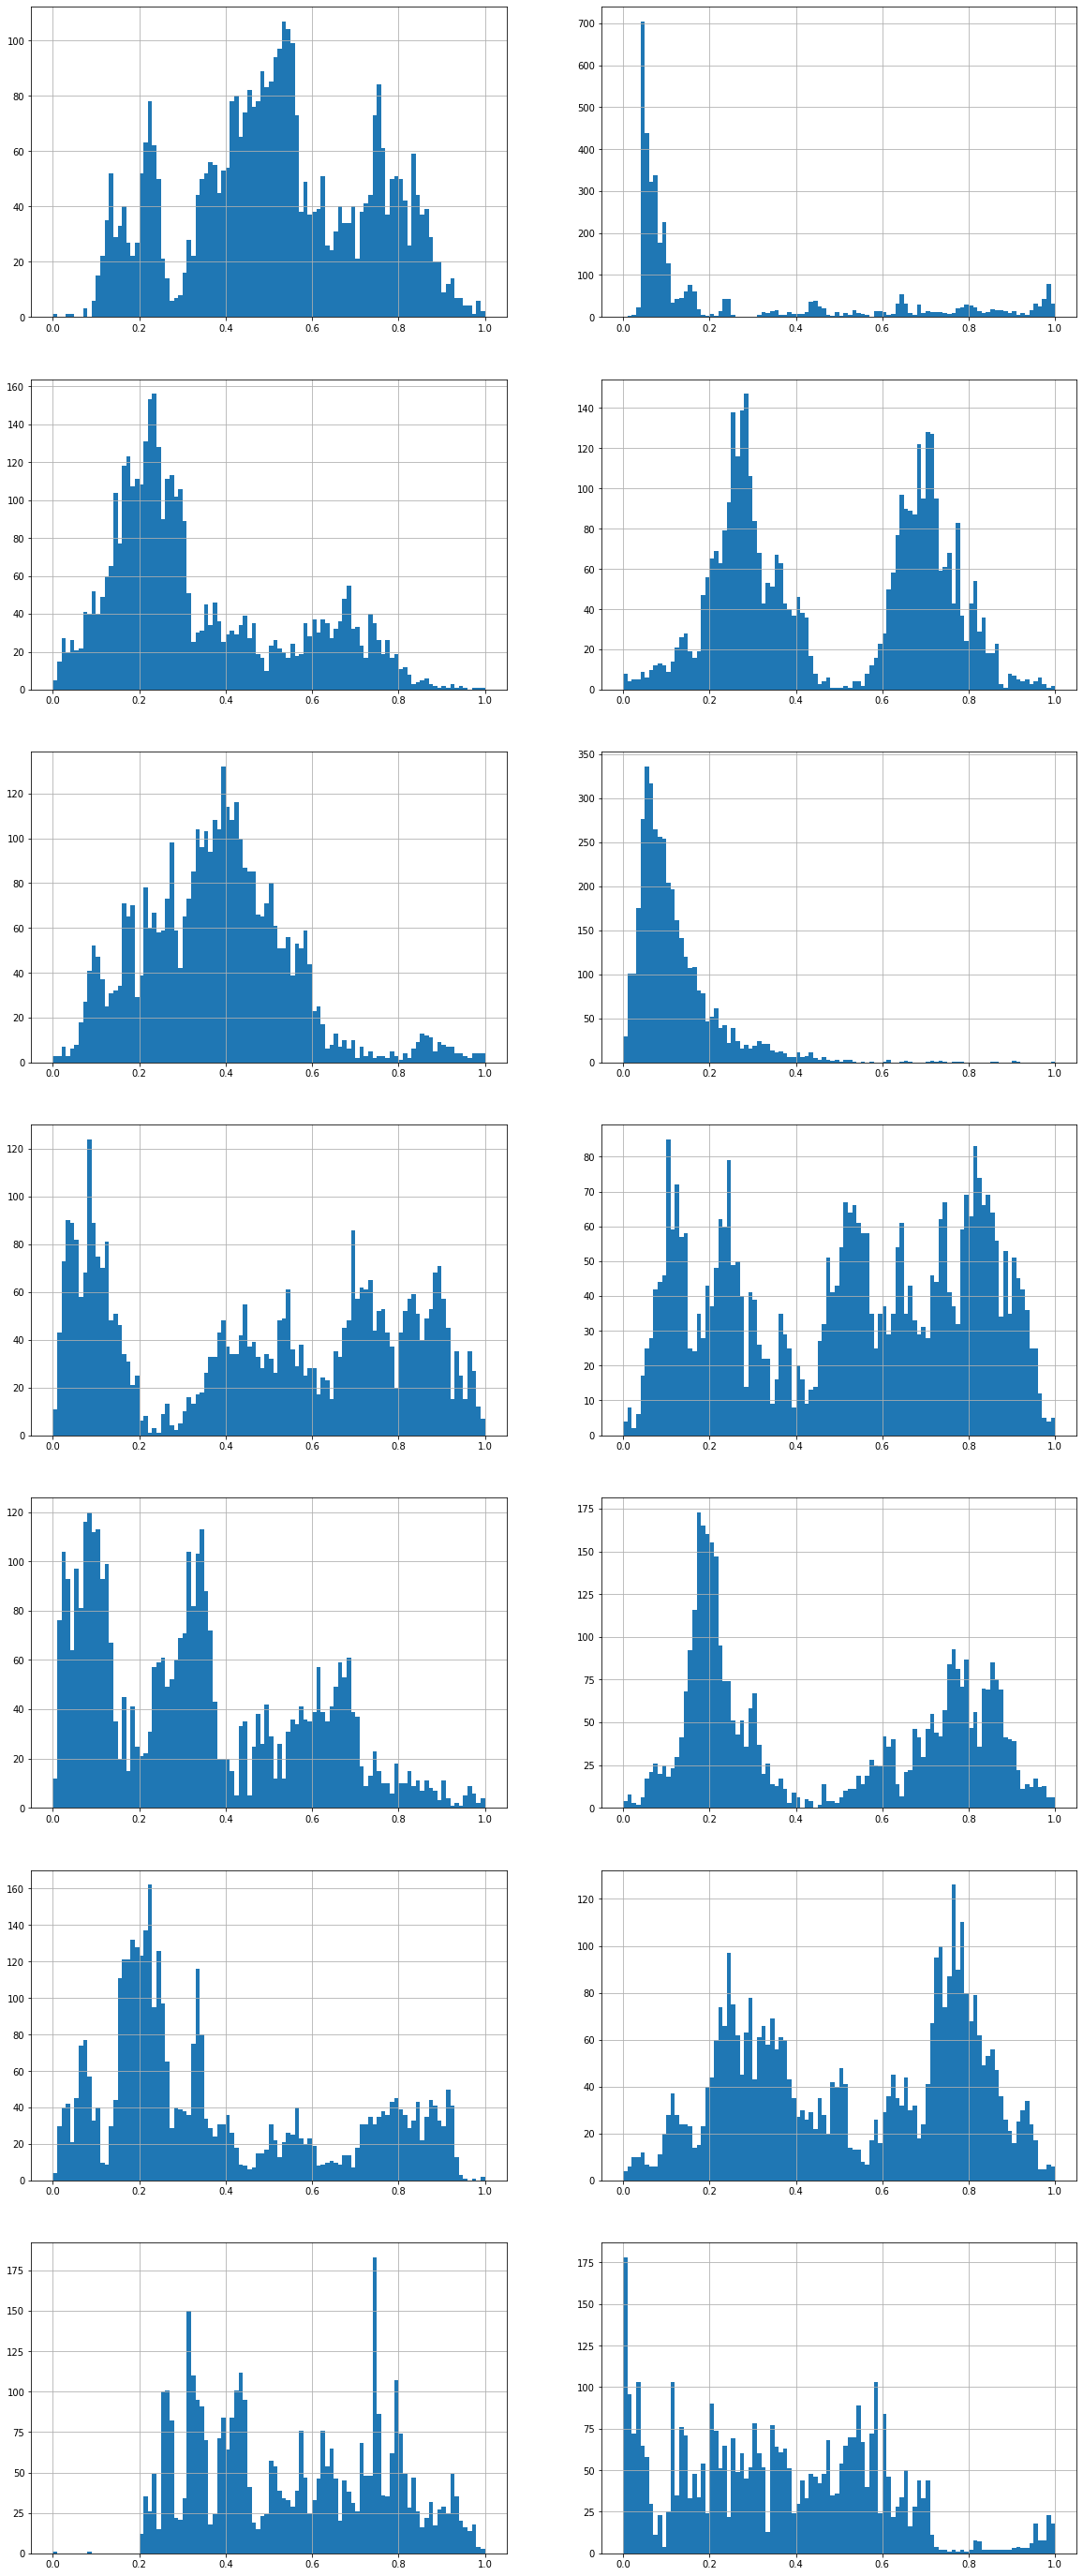

In [278]:
# Plots the distribution of the features.
plt.figure(figsize=(20, 50))
for i in range(14):
    plt.subplot(7, 2, i+1)
    data_scaled.iloc[:, i].hist(bins=100)
plt.show()

In [279]:
models = hdmr1.get_models()

In [280]:
def f(x, i):
    return models[i].predict(np.array([[x]]))[0]
f = np.vectorize(f)

In [281]:
column_names = data_scaled.columns.tolist()

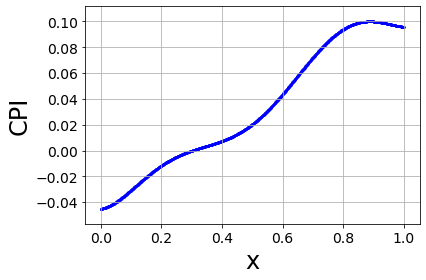

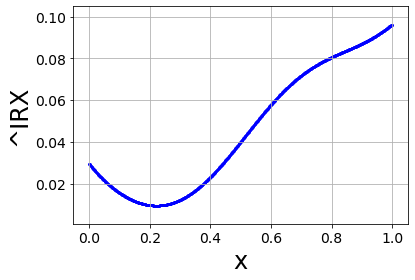

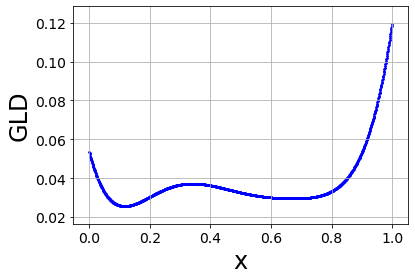

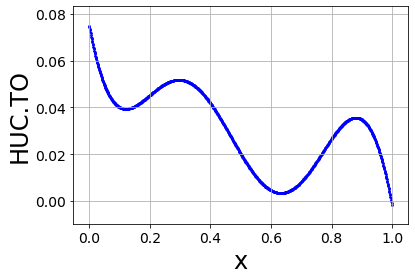

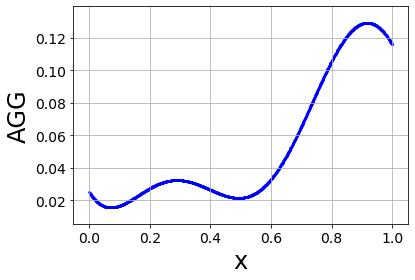

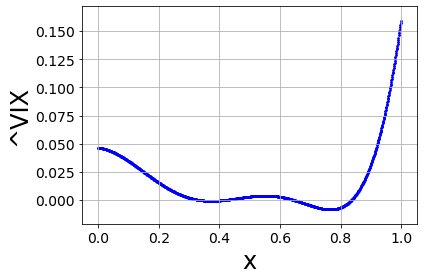

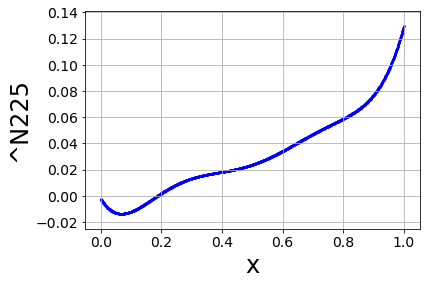

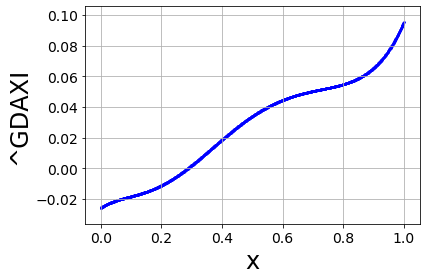

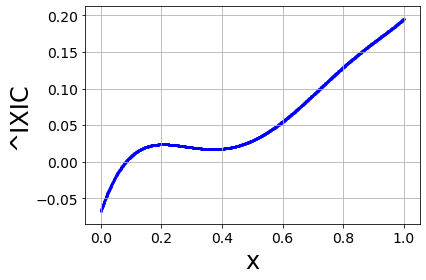

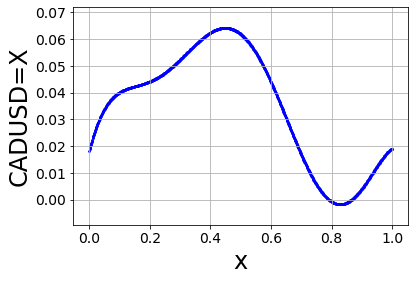

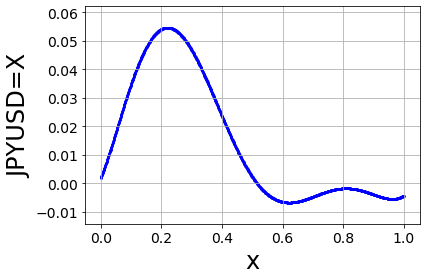

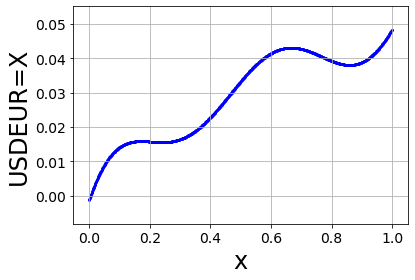

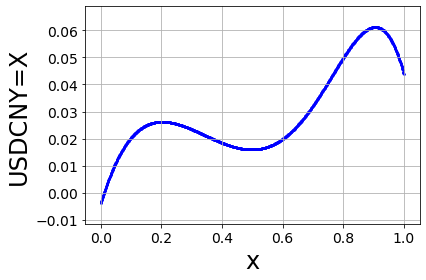

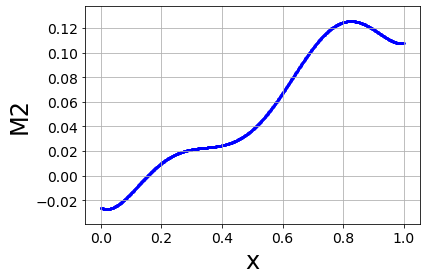

In [282]:
x = np.arange(0, 1, 0.001)
for i in range(14):
    plot_for_paper(x, f(x, i), xlabel='x', ylabel=column_names[i], name=f'Component_{i}.png', save=True)
#     plt.figure()
#     plt.ylabel(column_names[i], size=24)
#     plt.xlabel('x', size=24)
#     plt.scatter(x, f(x, i), c='b')
#     plt.savefig(f'Component_{i}.png', dpi=800, bbox_inches='tight')

In [61]:
def test_impute(col=2):
    x_train_na = x_train.copy()
    x_train_na.iloc[np.arange(0, 200, 2), col] = np.nan
    df_na = x_train_na.copy()
    
    foimp = FirstOrderHDMRImpute(models=models)
    foimp.get_yi(df_na)
    
    _, nan_rows_index, null_entry, candidates = foimp.impute(df_na, get_candidates=True, threshold=0)
    
    true = x_train.iloc[np.arange(0, 200, 2), col]
    
    correct = []
    correct_idxs = []
    for i in range(true.shape[0]):
        true_val = true.iloc[i]
        closests = []
        for j in candidates[i]:
            closests.append(abs(j - true_val))
        idx = closests.index(min(closests))
        correct_idxs.append(idx)
        correct.append(candidates[i][idx])
    
    t = []
    im = []
    c = []
    m = 0
    choices = pd.DataFrame(columns=['true', 'imputed', 'correct'])
    for i in range(len(correct)):
        can = candidates[i]
        t.extend([true.iloc[i]] * len(can))
        c.extend([False] * len(can))
        for j in range(len(can)):
            im.append(can[j])
        c[m + correct_idxs[i]] = True
        m += len(can)
    choices['true'] = t
    choices['imputed'] = im
    choices['correct'] = c
    
    false_choices = choices[choices['correct'] == False]
    true_choices = choices[choices['correct'] == True]
    
    print(math.sqrt(mean_squared_error(true_choices['true'], true_choices['imputed'])))
    plt.figure()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(f'Imputed {column_names[col]}', fontsize=24)
    plt.ylabel(f'True {column_names[col]}', fontsize=24)
    p1 = plt.scatter(false_choices['true'], false_choices['imputed'], c='r', s=3)
    p2 = plt.scatter(true_choices['true'], true_choices['imputed'], c='b', s=3)
    plt.grid()
    plt.legend((p1, p2), ('Incorrect', 'Correct'))
    plt.savefig(f'Impute_{col}.png', dpi=800, bbox_inches='tight')
    
    return x_train_na, df_na, false_choices, true_choices

Function execution time took 6.133061408996582 seconds.
0.07200907418387595
Function execution time took 6.006487846374512 seconds.
0.16539905879961112
Function execution time took 6.101250410079956 seconds.
0.24785388717298745
Function execution time took 6.127664566040039 seconds.
0.17919804706253478
Function execution time took 5.976026296615601 seconds.
0.19205132806395583
Function execution time took 6.112492322921753 seconds.
0.4070382536695759
Function execution time took 6.06138801574707 seconds.
0.09011744343758496
Function execution time took 6.140263795852661 seconds.
0.10840621317588396
Function execution time took 6.077887296676636 seconds.
0.13000797805814537
Function execution time took 6.070177793502808 seconds.
0.08710521695682531
Function execution time took 6.148058652877808 seconds.
0.11807892936632684
Function execution time took 6.097012519836426 seconds.
0.2256687058345325
Function execution time took 6.093942880630493 seconds.
0.2643179801650804
Function executi

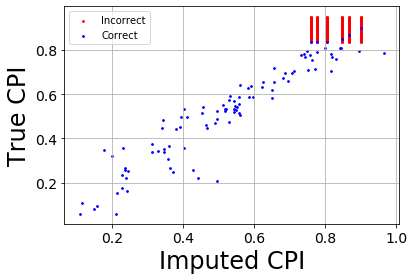

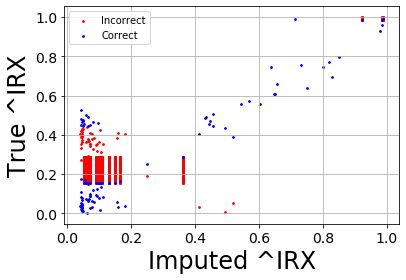

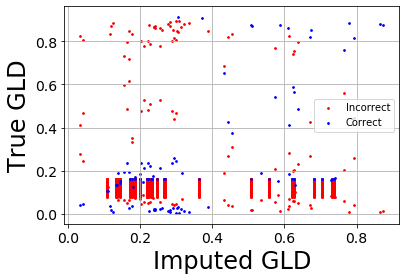

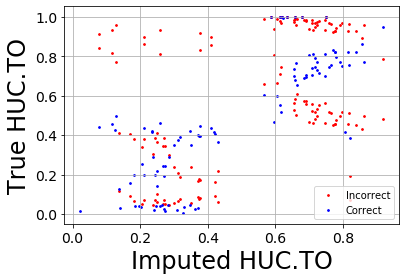

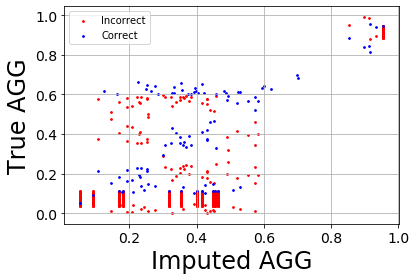

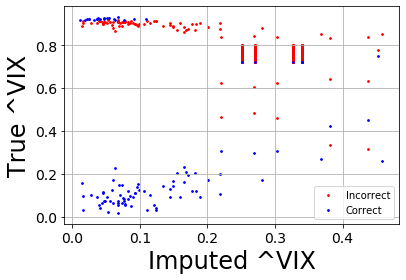

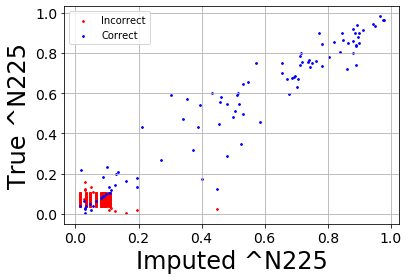

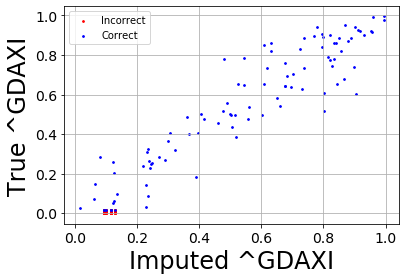

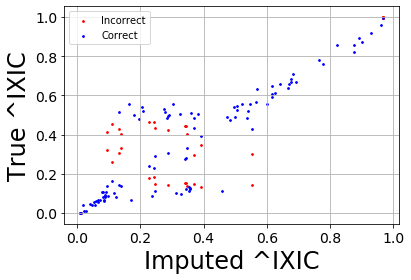

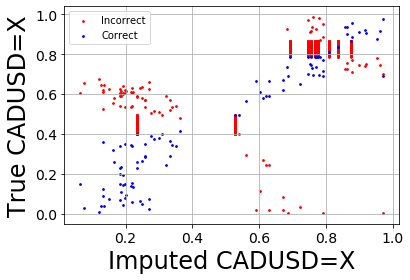

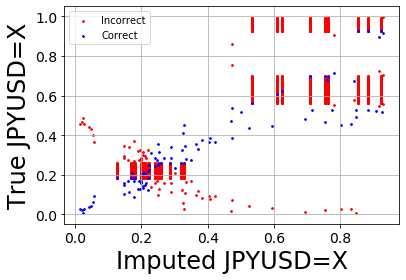

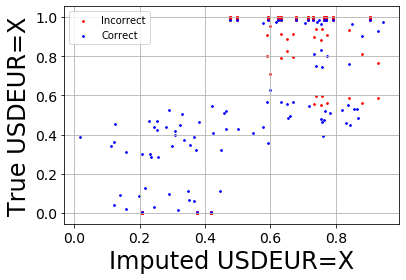

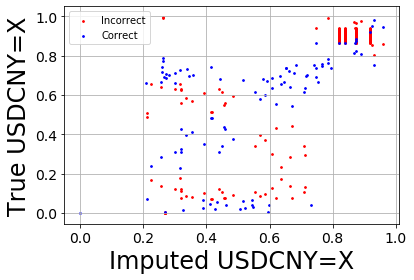

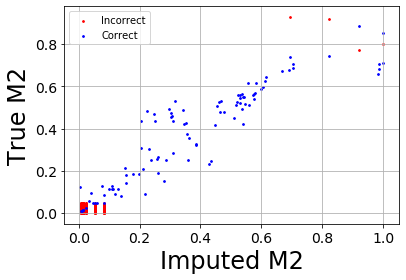

In [62]:
for i in range(14):
    _ = test_impute(i)

Function execution time took 6.343380451202393 seconds.
0.07295109156973982


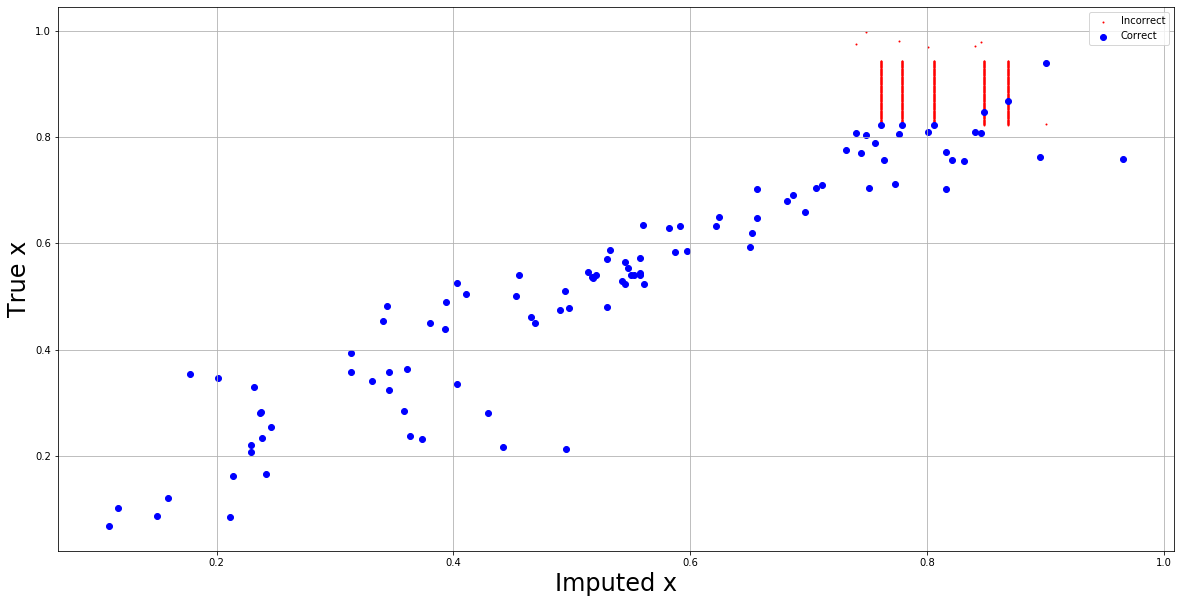

Function execution time took 6.213621616363525 seconds.
0.1455249822811172


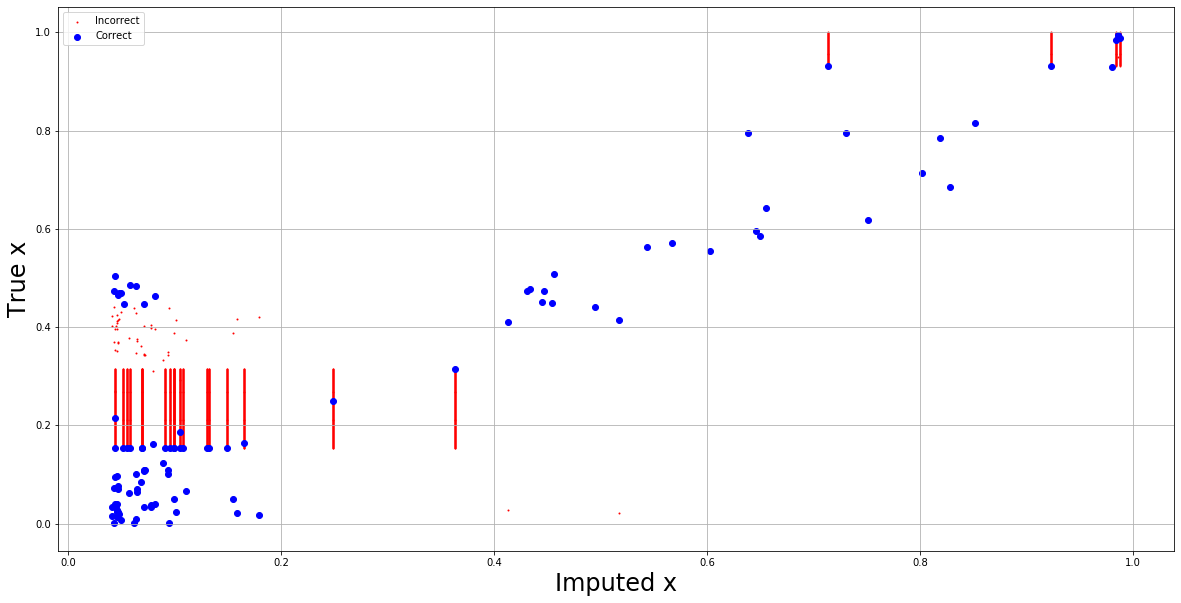

Function execution time took 6.188878536224365 seconds.
0.2452749701478167


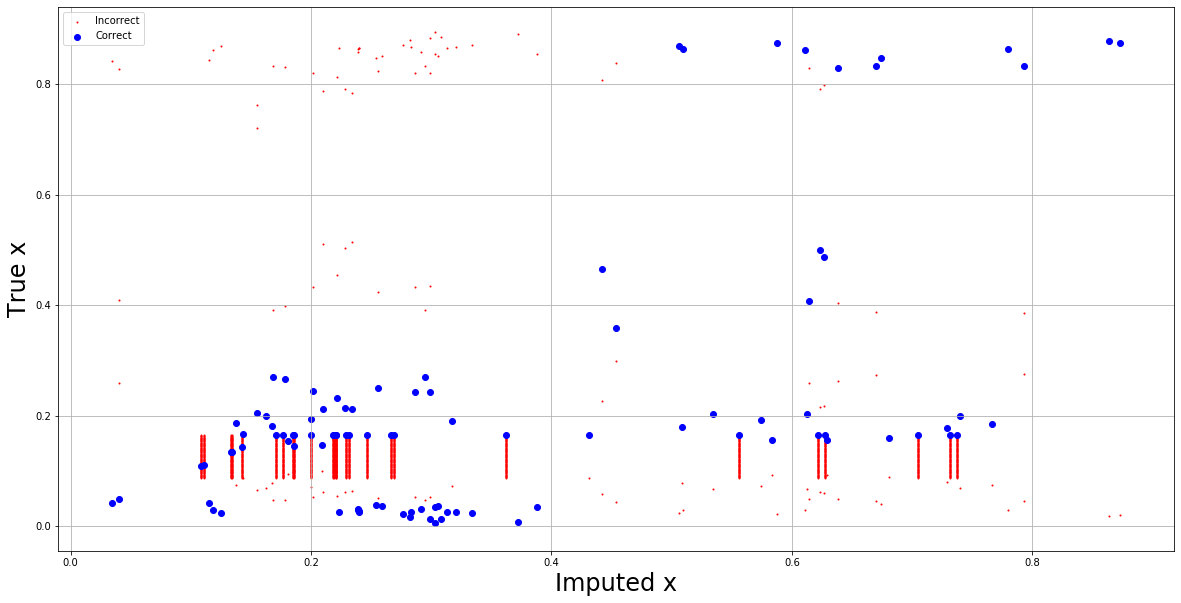

Function execution time took 6.326484203338623 seconds.
0.13477667173736185


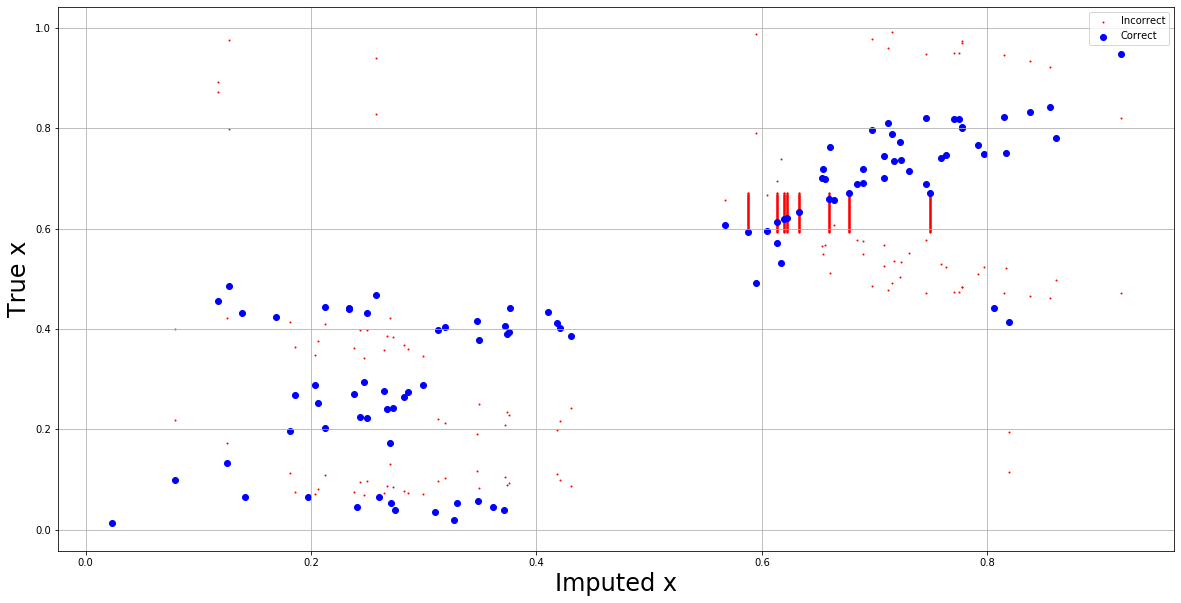

Function execution time took 6.266991853713989 seconds.
0.18551258889389216


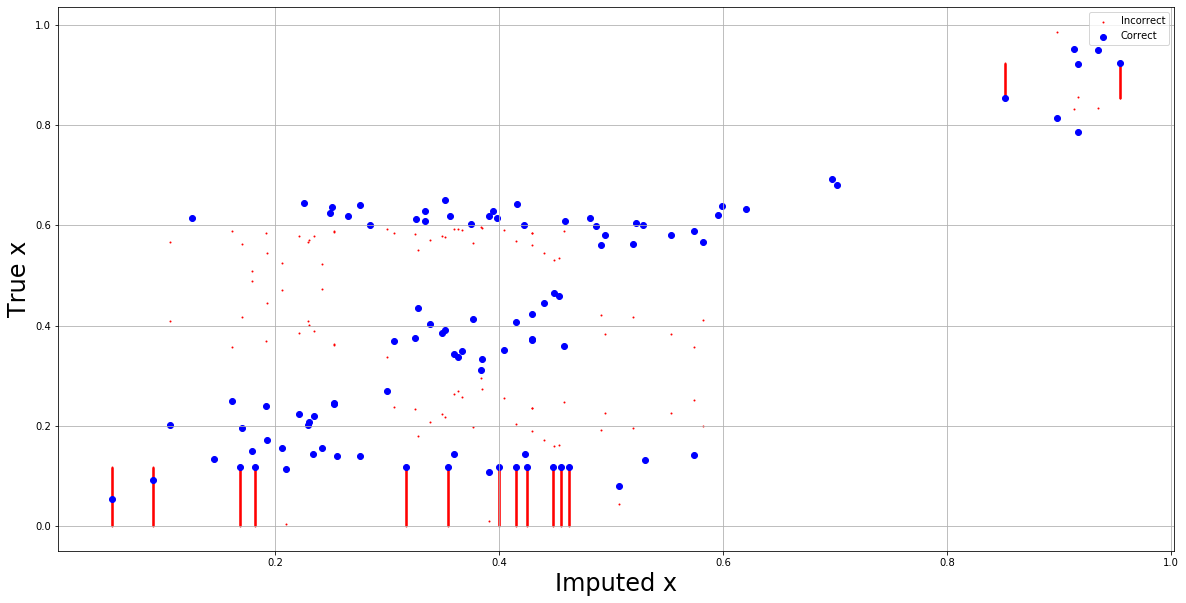

Function execution time took 6.295441627502441 seconds.
0.35721145371250734


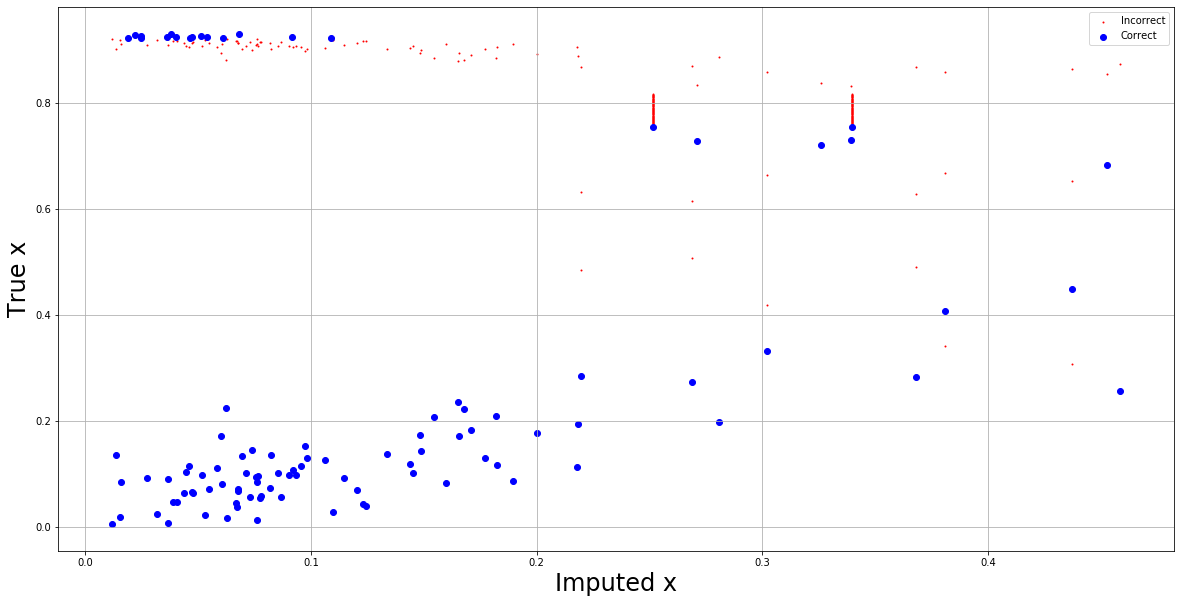

Function execution time took 6.266695022583008 seconds.
0.08887452111130877


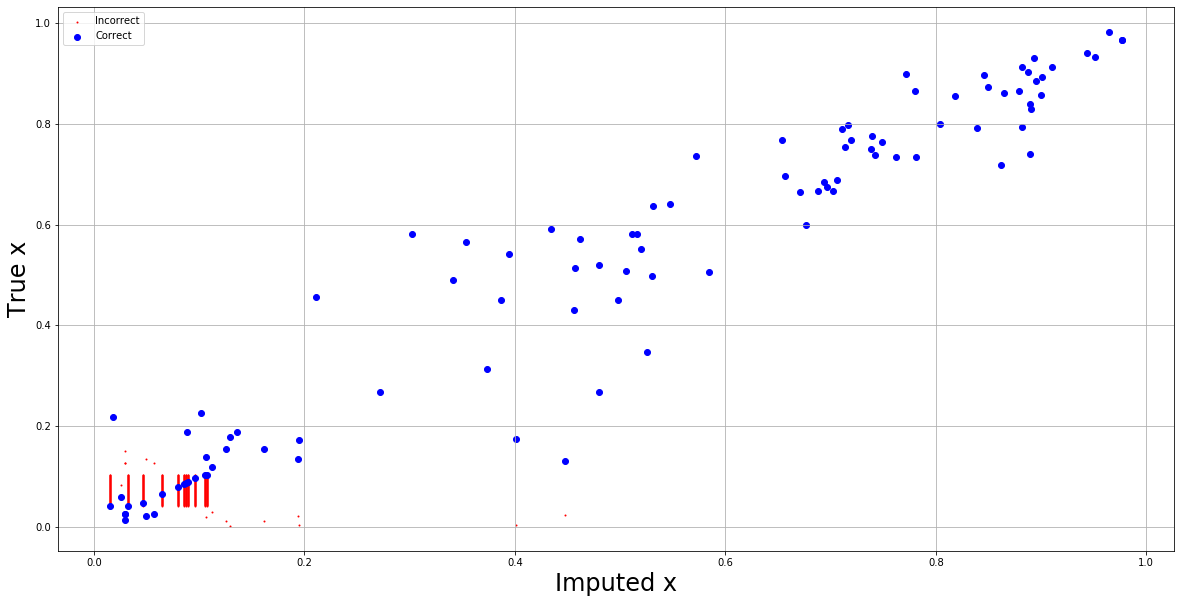

Function execution time took 6.411435842514038 seconds.
0.09831767616786793


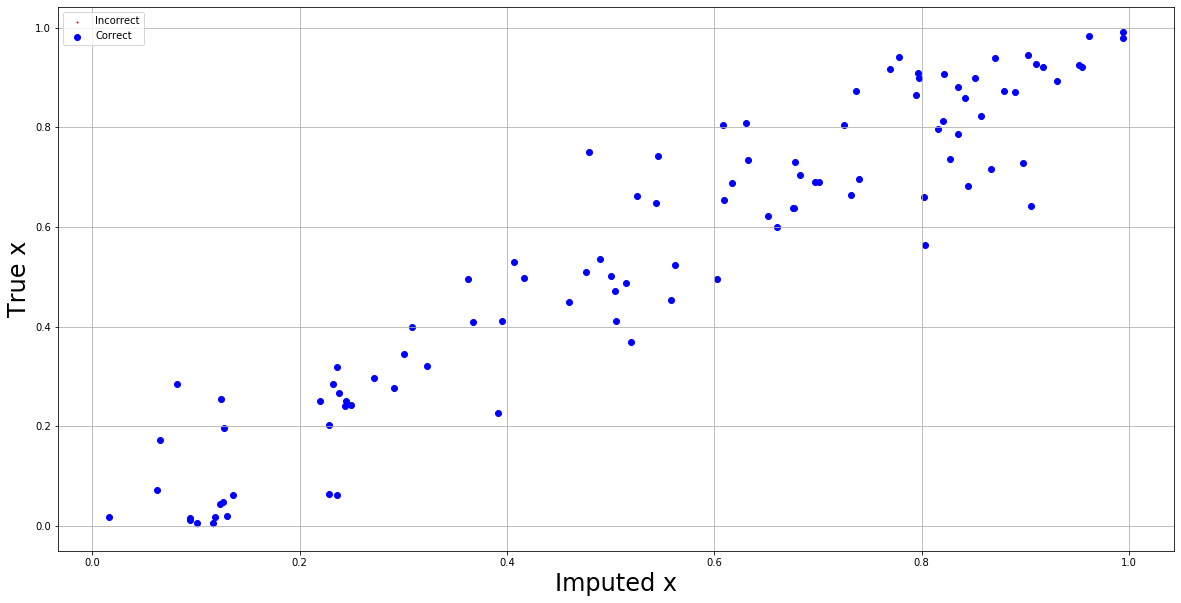

Function execution time took 6.139214277267456 seconds.
0.13854253138973494


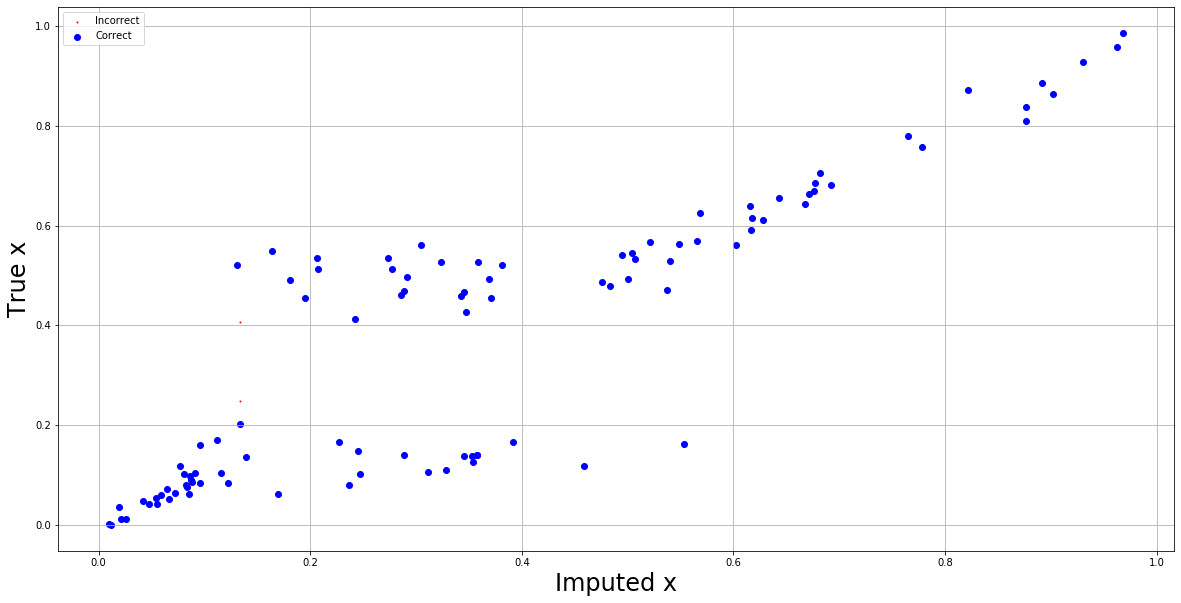

Function execution time took 6.338035345077515 seconds.
0.09827918357386436


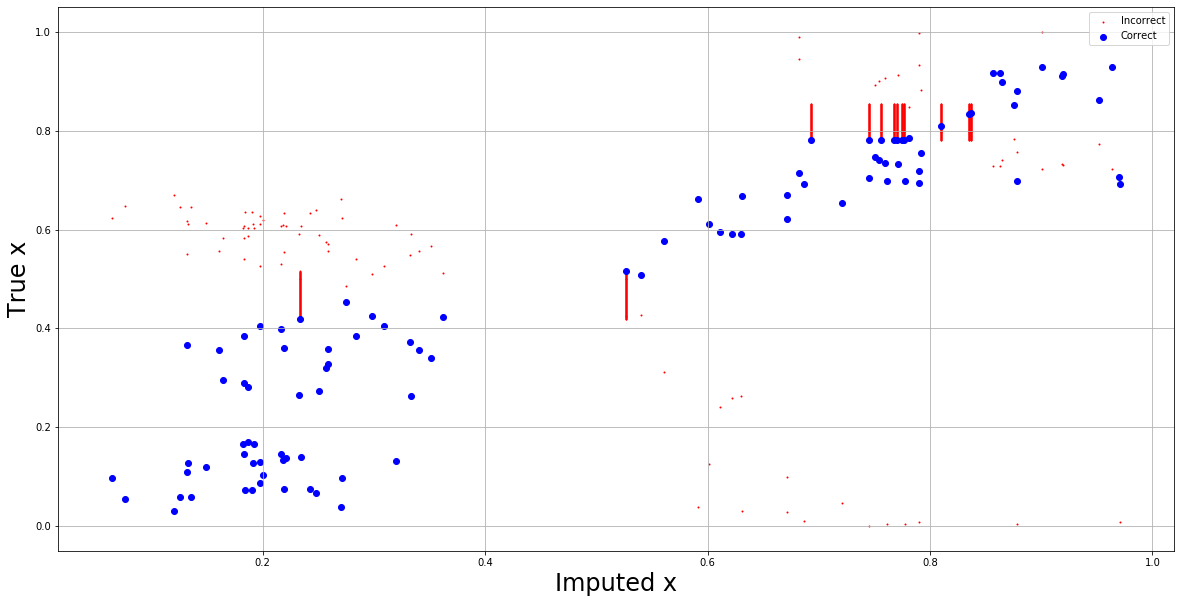

Function execution time took 6.184028387069702 seconds.
0.13845711274562986


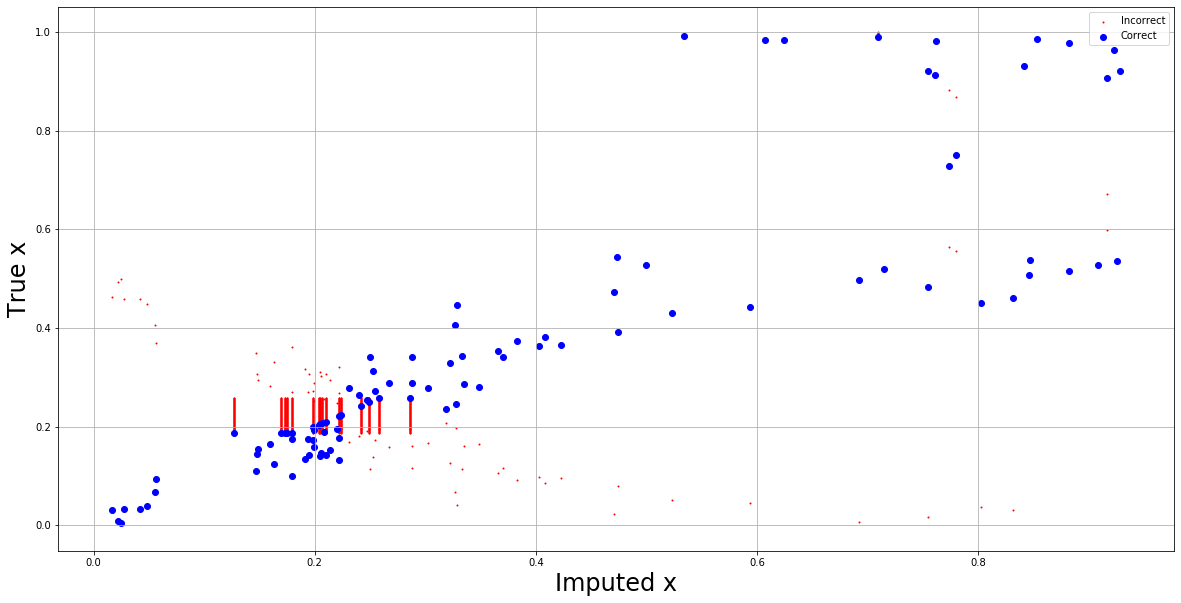

Function execution time took 6.156012773513794 seconds.
0.1828320414841175


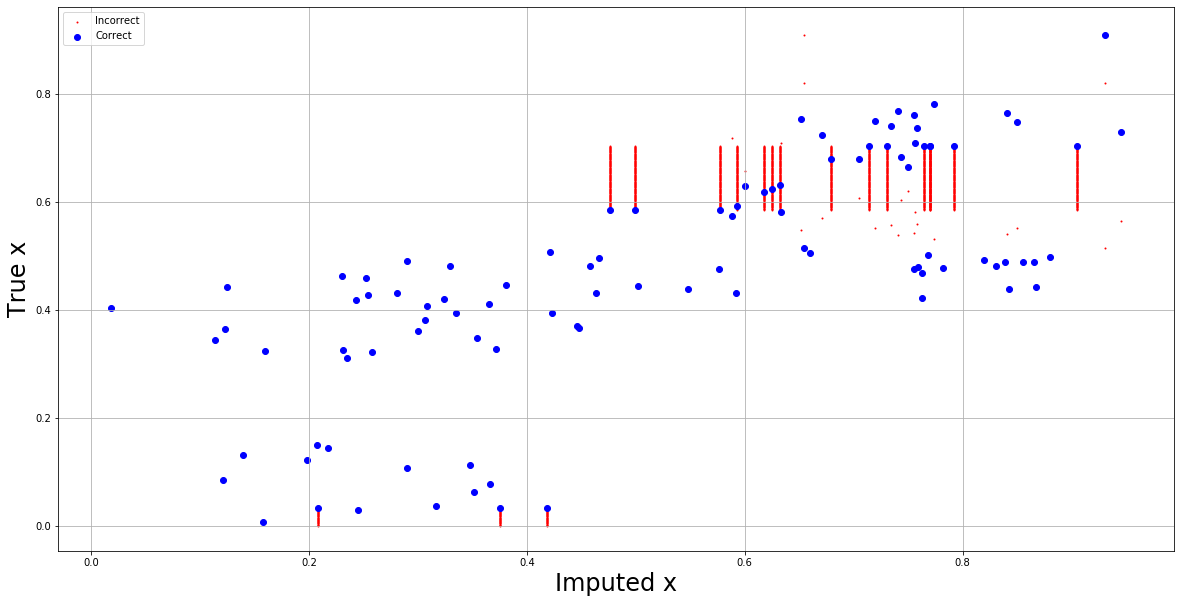

Function execution time took 6.149895668029785 seconds.
0.2620333204650553


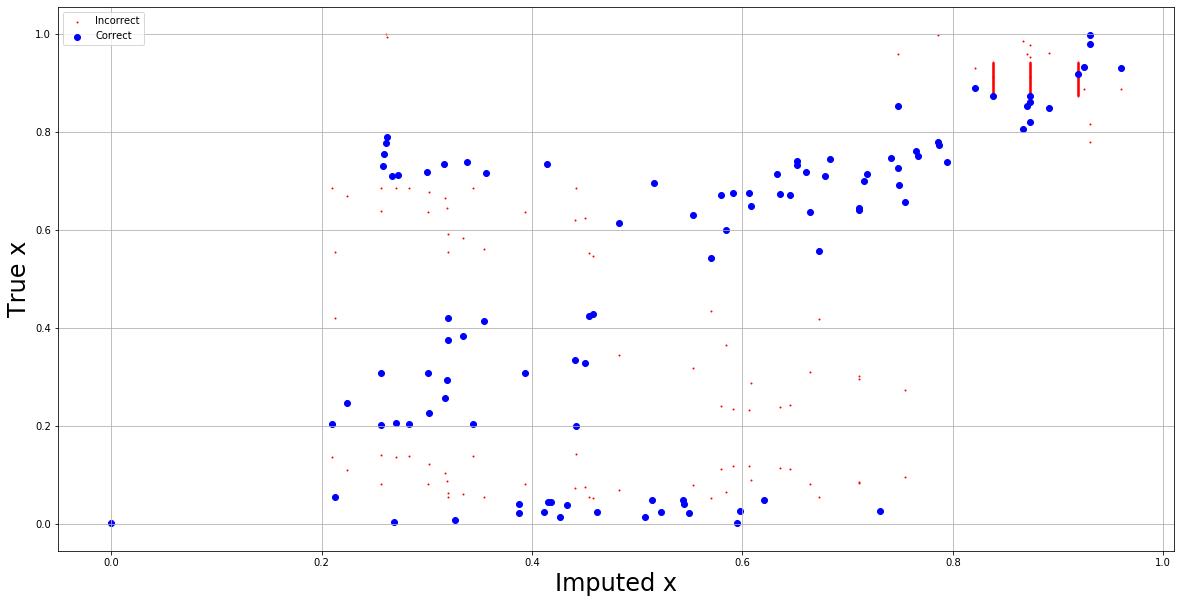

Function execution time took 6.2046027183532715 seconds.
0.09989354672286728


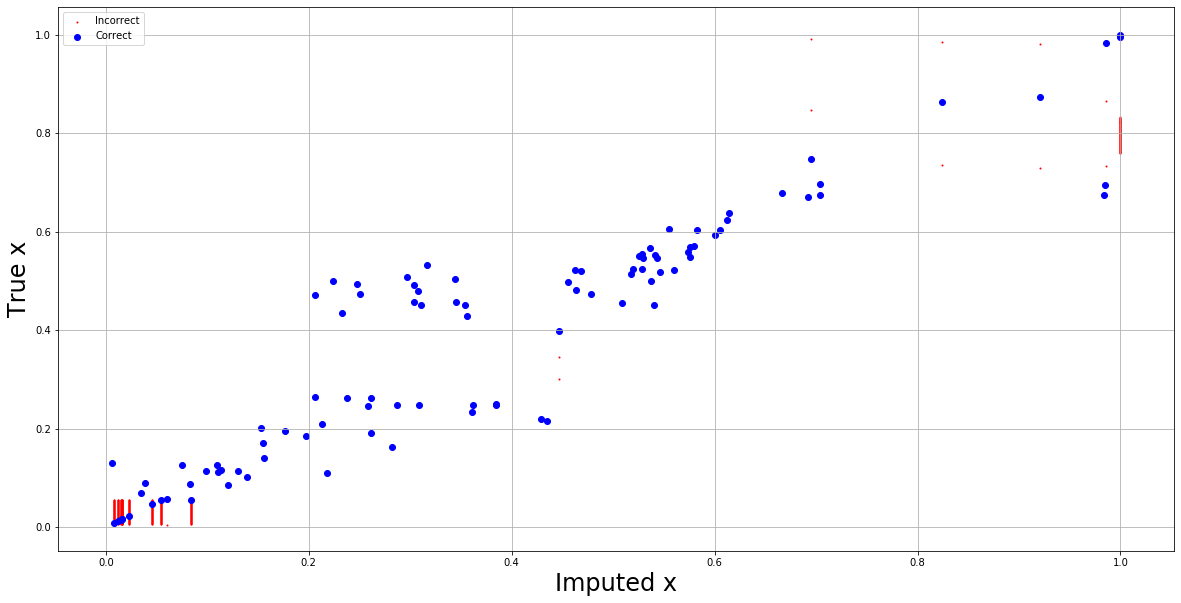

In [14]:
for i in range(14):
    _ = test_impute(i)